In [ ]:
#change the path to get the location of data
%cd drive/My Drive/Colab Notebooks

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks'
/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install scorecardpy

In [ ]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scorecardpy as sc


In [ ]:
#load the bond data
df=pd.read_csv('CC_Modeling_Data.txt', header=None, delimiter='\t', encoding= 'unicode_escape')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#read column names from excel file
columns=pd.read_excel('CC_VariablesList.xlsx')['Var_Title'].values
df.columns=columns

In [ ]:
#replace white space with np.nan 
df.replace(" ", pd.NA, inplace=True)

In [ ]:
df.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,STATE_OF_BIRTH,CITY_OF_BIRTH,NACIONALITY,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,FLAG_RESIDENCIAL_PHONE,RESIDENCIAL_PHONE_AREA_CODE,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_MOBILE_PHONE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,COMPANY,PROFESSIONAL_STATE,PROFESSIONAL_CITY,PROFESSIONAL_BOROUGH,FLAG_PROFESSIONAL_PHONE,PROFESSIONAL_PHONE_AREA_CODE,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,RN,Assu,1,RN,Santana do Matos,Centro,Y,105,1.0,15.0,N,1,900.0,0.0,1,1,0,0,0,0,0,0.0,0,N,<NA>,NaN,NaN,N,<NA>,0,9.0,4.0,NaN,NaN,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,RJ,rio de janeiro,1,RJ,RIO DE JANEIRO,CAMPO GRANDE,Y,20,1.0,1.0,N,1,750.0,0.0,0,0,0,0,0,0,0,0.0,0,Y,<NA>,NaN,NaN,N,<NA>,0,11.0,4.0,11.0,NaN,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,RN,GARANHUNS,1,RN,Parnamirim,Boa Esperanca,Y,105,1.0,NaN,N,1,500.0,0.0,0,0,0,0,0,0,0,0.0,0,N,<NA>,NaN,NaN,N,<NA>,0,11.0,NaN,NaN,NaN,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,PE,CABO,1,PE,CABO,PONTE DOS CARVALHOS,N,<NA>,NaN,NaN,N,1,500.0,0.0,0,0,0,0,0,0,0,0.0,0,N,<NA>,NaN,NaN,N,<NA>,0,NaN,NaN,NaN,NaN,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,RJ,RIO DE JANEIRO,1,RJ,Rio de Janeiro,Santa Cruz,Y,20,1.0,12.0,N,1,1200.0,0.0,0,0,0,0,0,0,0,0.0,0,N,<NA>,NaN,NaN,N,<NA>,0,9.0,5.0,NaN,NaN,0,0,0,0,1,N,48,235,235,1


In [ ]:
df.shape

(50000, 54)

In [ ]:
df.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD=1
count,50000.000000,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,42244.000000,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,25000.500000,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,0.802280,886.678437,35.434760,0.111440,0.097460,0.001320,0.001740,0.002040,0.357840,0.357840,2.322372e+03,0.336140,0.009320,8.061784,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,14433.901067,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,0.398284,7846.959327,891.515142,0.314679,0.296586,0.036308,0.041677,0.045121,0.479953,0.479953,4.235798e+04,0.472392,0.383453,3.220104,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,12500.750000,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,25000.500000,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,1.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,37500.250000,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,1.000000,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,9.000000,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,50000.000000,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,1.000000,959000.000000,194344.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,6.000000e+06,1.000000,35.000000,18.000000,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


# 1. Data Preparation

In [ ]:
#let's drop SEX feature which should not be included in the scorecard.
df.drop('SEX', axis='columns', inplace=True)

In [ ]:
#First split data into training and test data set to avoid information leakage from training to train
train, test = sc.split_df(df.iloc[:,0:],
                          y = 'TARGET_LABEL_BAD=1',
                          ratio = 0.8,
                          seed = 251256082).values()

## 1.1 Null values

In [ ]:
#select features which have null values
null_columns=train.columns[train.isnull().any()]
number_of_null=pd.DataFrame(train[null_columns].isnull().sum()).reset_index()
number_of_null.columns=['Feature', 'Number_of_null_values']
# missing value percentage
number_of_null['Ratio_of_null_values(%)']=100*np.array(train[null_columns].isnull().sum()/train.shape[0])
display(number_of_null)

,Feature,Number_of_null_values,Ratio_of_null_values(%)
0,STATE_OF_BIRTH,1676,4.1900
1,CITY_OF_BIRTH,1676,4.1900
2,RESIDENCIAL_BOROUGH,5,0.0125
3,RESIDENCIAL_PHONE_AREA_CODE,6597,16.4925
4,RESIDENCE_TYPE,1080,2.7000
5,MONTHS_IN_RESIDENCE,3048,7.6200
6,PROFESSIONAL_STATE,27455,68.6375
7,PROFESSIONAL_CITY,27309,68.2725
8,PROFESSIONAL_BOROUGH,27799,69.4975
9,PROFESSIONAL_PHONE_AREA_CODE,29279,73.1975


RESIDENCIAL_BOROUGH 

In [ ]:
# Since only 5 records are missing, it is safe to fill the null value with mode
train['RESIDENCIAL_BOROUGH'].fillna(train['RESIDENCIAL_BOROUGH'].mode()[0], inplace=True)

In [ ]:
# fill the test data with training data's mode to avoid information leakage
test['RESIDENCIAL_BOROUGH'].fillna(train['RESIDENCIAL_BOROUGH'].mode()[0], inplace=True)

RESIDENCE_TYPE


In [ ]:
#since only 2.7% of data in RESIDENCE_TYPE are missing, it is safe to fill the null value with mode
train['RESIDENCE_TYPE'].fillna(train['RESIDENCE_TYPE'].mode()[0], inplace=True)

In [ ]:
# fill the test data with training data's mode to avoid information leakage
test['RESIDENCE_TYPE'].fillna(train['RESIDENCE_TYPE'].mode()[0], inplace=True)

PROFESSIONAL_STATE

In [ ]:
#number of rows where PROFESSIONAL_STATE and RESIDENCIAL_STATE both have not null values.
tolNumRow=train.loc[train['PROFESSIONAL_STATE'].notnull(), ['RESIDENCIAL_STATE', 'PROFESSIONAL_STATE']].shape[0]

#number of rows where RESIDENCIAL_CITY and PROFESSIONAL_CITY have same values.
numMatchedRow=train.loc[train['RESIDENCIAL_STATE']==train['PROFESSIONAL_STATE'], ['RESIDENCIAL_STATE', 'PROFESSIONAL_STATE']].count()

#print out the ratio of how many records where RESIDENCIAL_CITY and PROFESSIONAL_CITY have same values.
print(f" Percentage of rows where RESIDENCIAL_STATE and PROFESSIONAL_STATE have same values: {numMatchedRow/tolNumRow*100}")

 Percentage of rows where RESIDENCIAL_STATE and PROFESSIONAL_STATE have same values: RESIDENCIAL_STATE     98.222399
PROFESSIONAL_STATE    98.222399
dtype: float64


For the rows where both RESIDENTIAL_STATE and PROFESSIONAL_STATE have not null values, the number of rows where RESIDENTIAL_STATE and PROFESSIONAL_STATE have same values takes up to 98.22%. Therefore, it is confident to say that at least 98.15% of data have the same values and thus I can fill the missing values in PROFESSIONAL_STATE using values of RESIDENTIAL_STATE, which also makes sense since most of people live and work at the same STATE.

In [ ]:
train['PROFESSIONAL_STATE'].fillna(train.RESIDENCIAL_STATE, inplace=True)

In [ ]:
#fill the missing value in test data
test['PROFESSIONAL_STATE'].fillna(test.RESIDENCIAL_STATE, inplace=True)

PROFESSIONAL_CITY

In [ ]:
#number of rows where RESIDENCIAL_CITY and PROFESSIONAL_CITY both have not null values.
tolNumRow=train.loc[train['PROFESSIONAL_CITY'].notnull(), ['RESIDENCIAL_CITY', 'PROFESSIONAL_CITY']].shape[0]

#number of rows where RESIDENCIAL_CITY and PROFESSIONAL_CITY have same values.
numMatchedRow=train.loc[train['RESIDENCIAL_CITY']==train['PROFESSIONAL_CITY'], ['RESIDENCIAL_CITY', 'PROFESSIONAL_CITY']].count()

#print out the ratio of how many records where RESIDENCIAL_CITY and PROFESSIONAL_CITY have same values.
print(f" Percentage of rows where RESIDENCIAL_CITY and PROFESSIONAL_CITY have same values: {numMatchedRow/tolNumRow*100}")

 Percentage of rows where RESIDENCIAL_CITY and PROFESSIONAL_CITY have same values: RESIDENCIAL_CITY     65.314002
PROFESSIONAL_CITY    65.314002
dtype: float64


For the rows where both RESIDENTIAL_CITY and PROFESSIONAL_CITY have not null values, the number of rows where RESIDENTIAL_CITY and PROFESSIONAL_CITY have same values takes up to 65.31%. Therefore, it is confident to say that at least 65.31% of data have the same values and thus I can fill the missing values in PROFESSIONAL_CITY using values of RESIDENTIAL_CITY, which also makes sense since most of people live and work at the same city.

In [ ]:
train['PROFESSIONAL_CITY'].fillna(train.RESIDENCIAL_CITY, inplace=True)

In [ ]:
#fill the test data
test['PROFESSIONAL_CITY'].fillna(test.RESIDENCIAL_CITY, inplace=True)

PROFESSIONAL_BOROUGH

In [ ]:
#number of rows where PROFESSIONAL_BOROUGH and RESIDENCIAL_BOROUGH both have not null values.
tolNumRow=train.loc[train['PROFESSIONAL_BOROUGH'].notnull(), ['RESIDENCIAL_BOROUGH', 'PROFESSIONAL_BOROUGH']].shape[0]

#number of rows where RESIDENCIAL_CITY and PROFESSIONAL_CITY have same values.
numMatchedRow=train.loc[train['RESIDENCIAL_BOROUGH']==train['PROFESSIONAL_BOROUGH'], ['RESIDENCIAL_BOROUGH', 'PROFESSIONAL_BOROUGH']].count()

#print out the ratio of how many records where RESIDENCIAL_CITY and PROFESSIONAL_CITY have same values.
print(f" Percentage of rows where RESIDENCIAL_BOROUGH and PROFESSIONAL_BOROUGH have same values: {numMatchedRow/tolNumRow*100}")

 Percentage of rows where RESIDENCIAL_BOROUGH and PROFESSIONAL_BOROUGH have same values: RESIDENCIAL_BOROUGH     16.55602
PROFESSIONAL_BOROUGH    16.55602
dtype: float64


Only 16.55% of PROFRSSIONAL_BOROUGH and RESIDENCIAL_BOROUGH data are the same, so I cannot use value of RESIDENCIAL_BOROUGH to fill missing values in PROFESSIONAL_BOROUGH. Also the missing value of PROFESSIONAL_BOROUGH is up to 69.5%, so it will be deleted.

In [ ]:
train.drop('PROFESSIONAL_BOROUGH', axis='columns', inplace=True)

In [ ]:
#drop the column in test data as well
test.drop('PROFESSIONAL_BOROUGH', axis='columns', inplace=True)

PROFESSION_CODE

In [ ]:
train.loc[train['PROFESSION_CODE'].isnull(), ['PROFESSIONAL_CITY', 'PROFESSIONAL_STATE']]

,PROFESSIONAL_CITY,PROFESSIONAL_STATE
21,PACATUBA,CE
23,FORTALEZA,CE
28,Sao Paulo,SP
36,Mossoro,RN
39,Mossoro,RN
...,...,...
49976,BIGUACU,SC
49980,SANTA MARIA,DF
49990,Pelotas,RS
49991,PACATUBA,CE


The above result shows that missing value of PROFESSION_CODE cannot be simply treated as these customers do not have job. So the best way is to group the profession_code by PROFESSIONAL_CITY and find the mode for each PROFESSIONAL_CITY, and then use the mode to fill the mising values.

In [ ]:
def fill_mode(city_mode, df):
  '''
  Function to use mode of profession_code in each professional_city to fill the missing values in each professional_city
  '''
  cities=list(city_mode.PROFESSIONAL_CITY.unique())
  for city in cities:
    df.loc[df['PROFESSIONAL_CITY']==city, 'PROFESSION_CODE']=df.loc[df['PROFESSIONAL_CITY']==city, 'PROFESSION_CODE'].fillna(np.array(city_mode[city_mode['PROFESSIONAL_CITY']==city].PROFESSION_CODE)[0])

#find the mode of profession_code in each professional_city
city_mode=pd.DataFrame(train.groupby('PROFESSIONAL_CITY').PROFESSION_CODE.apply(lambda x: x.mode())).reset_index()

#update the missing values
fill_mode(city_mode, train)

In [ ]:
train['PROFESSION_CODE'].isnull().sum()

483

In [ ]:
#fill the rest of missing values using global mode
train['PROFESSION_CODE'].fillna(train['PROFESSION_CODE'].mode()[0], inplace=True)

In [ ]:
train['PROFESSION_CODE'].isnull().sum()

0

In [ ]:
#fill the test data
fill_mode(city_mode, test)

In [ ]:
test['PROFESSION_CODE'].isnull().sum()

112

In [ ]:
#fill the rest of missing values in test data using global mode from train data
test['PROFESSION_CODE'].fillna(train['PROFESSION_CODE'].mode()[0], inplace=True)

In [ ]:
test['PROFESSION_CODE'].isnull().sum()

0

OCCUPATION_TYPE

Similarly as the PROFESSION_CODE, The below result shows that missing value of OCCUPATION_TYPE cannot be simply treated as these customers do not have job. So the best way is to group the OCCUPATION_TYPE by PROFESSIONAL_CITY and find the mode for each OCCUPATION_TYPE, and then use the mode to fill the mising values.

In [ ]:
train.loc[train['OCCUPATION_TYPE'].isnull(), ['PROFESSIONAL_CITY', 'PROFESSIONAL_STATE']]

,PROFESSIONAL_CITY,PROFESSIONAL_STATE
2,Parnamirim,RN
14,NATAL,RN
28,Sao Paulo,SP
36,Mossoro,RN
39,Mossoro,RN
...,...,...
49966,PINDARE MIRIM,MA
49973,COELHO NETO,MA
49980,SANTA MARIA,DF
49990,Pelotas,RS


In [ ]:
def fill_mode(city_type, df):
  '''
  Function to use mode of occupation_type in each professional_city to fill the missing values in each professional_city
  '''
  cities=list(city_type.PROFESSIONAL_CITY.unique())
  for city in cities:
    df.loc[df['PROFESSIONAL_CITY']==city, 'OCCUPATION_TYPE']=df.loc[df['PROFESSIONAL_CITY']==city, 'OCCUPATION_TYPE'].fillna(np.array(city_type[city_type['PROFESSIONAL_CITY']==city].OCCUPATION_TYPE)[0])

#find the mode of profession_code in each professional_city
city_type=pd.DataFrame(train.groupby('PROFESSIONAL_CITY').OCCUPATION_TYPE.apply(lambda x: x.mode())).reset_index()

#update the missing values
fill_mode(city_type, train)

In [ ]:
train['OCCUPATION_TYPE'].isnull().sum()

607

In [ ]:
#fill the rest of missing values using global mode
train['OCCUPATION_TYPE'].fillna(train['OCCUPATION_TYPE'].mode()[0], inplace=True)

In [ ]:
train['OCCUPATION_TYPE'].isnull().sum()

0

In [ ]:
# fill the test data 
fill_mode(city_type, test)

In [ ]:
test['OCCUPATION_TYPE'].isnull().sum()

129

In [ ]:
#fill the rest of missing values in test data using global mode from train data
test['OCCUPATION_TYPE'].fillna(train['OCCUPATION_TYPE'].mode()[0], inplace=True)

In [ ]:
test['OCCUPATION_TYPE'].isnull().sum()

0

MONTHS_IN_RESIDENCE

Fill the missing value with median

In [ ]:
train['MONTHS_IN_RESIDENCE'].fillna(train['MONTHS_IN_RESIDENCE'].median(), inplace=True)

In [ ]:
#fill the test data using train data's median
test['MONTHS_IN_RESIDENCE'].fillna(train['MONTHS_IN_RESIDENCE'].median(), inplace=True)

MATE_PROFESSION_CODE	

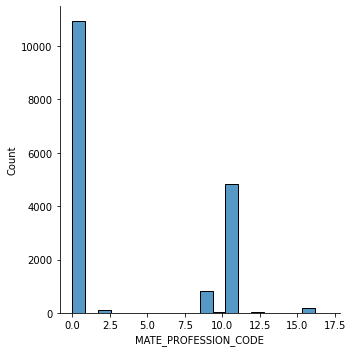

In [ ]:
sns.displot(train['MATE_PROFESSION_CODE'])

Some credit card applicants do not have mate, so it is a reasonable guess that missing value represents that the applicant does not have a mate, therefore, using a new placeholder to represent the non_mate status.

In [ ]:
train['MATE_PROFESSION_CODE'].fillna(train['MATE_PROFESSION_CODE'].max()+1, inplace=True)

In [ ]:
# fill the test data 
test['MATE_PROFESSION_CODE'].fillna(train['MATE_PROFESSION_CODE'].max()+1, inplace=True)

MATE_EDUCATION_LEVEL

In [ ]:
#fill the missing value using a new category
train['MATE_EDUCATION_LEVEL'].fillna(train['MATE_EDUCATION_LEVEL'].max()+1, inplace=True)

In [ ]:
# fill the test data
test['MATE_EDUCATION_LEVEL'].fillna(train['MATE_EDUCATION_LEVEL'].max()+1, inplace=True)

STATE_OF_BIRTH and CITY_OF_BIRTH

STATE_OF_BIRTH and CITY_OF_BIRTH seem having no relation with other columns. Nowadays it is very common to be born in one state or city and move to reside and work in other state or city. So, I cannot use columns like PROFESSIONAL_STATE (PROFESSIONAL_CITY) or RESIDENTIAL_STATE (RESIDENTIAL_CITY) to fill missing values. Without any further information, the only best method is filling null values with mode.

In [ ]:
train['STATE_OF_BIRTH'].fillna(train['STATE_OF_BIRTH'].mode()[0], inplace=True)
train['CITY_OF_BIRTH'].fillna(train['CITY_OF_BIRTH'].mode()[0], inplace=True)

In [ ]:
# fill the test data
test['STATE_OF_BIRTH'].fillna(train['STATE_OF_BIRTH'].mode()[0], inplace=True)
test['CITY_OF_BIRTH'].fillna(train['CITY_OF_BIRTH'].mode()[0], inplace=True)

PROFESSIONAL_PHONE_AREA_CODE

Since PROFESSIONAL_PHONE_AREA_CODE has up to 73.19% of data missing, so without additional information, it is safe to just delete the column

In [ ]:
train.drop('PROFESSIONAL_PHONE_AREA_CODE', axis='columns', inplace=True)

In [ ]:
# drop the column in the test data as well
test.drop('PROFESSIONAL_PHONE_AREA_CODE', axis='columns', inplace=True)

RESIDENCIAL_PHONE_AREA_CODE

Let's group the RESIDENCIAL_PHONE_AREA_CODE by the RESIDENTIAL_CITY column and find the most frequent value of RESIDENCIAL_PHONE_AREA_CODE for each RESIDENTIAL_CITY, and use this value to fill the missing value of RESIDENCIAL_PHONE_AREA_CODE in each RESIDENTIAL_CITY.

In [ ]:
def fill_mode(city_code, df):
  '''
  Function to use mode of RESIDENCIAL_PHONE_AREA_CODE in each professional_city to fill the missing values in each professional_city
  '''
  cities=list(city_code.PROFESSIONAL_CITY.unique())
  for city in cities:
    df.loc[df['PROFESSIONAL_CITY']==city, 'RESIDENCIAL_PHONE_AREA_CODE']=df.loc[df['PROFESSIONAL_CITY']==city, 'RESIDENCIAL_PHONE_AREA_CODE'].fillna(np.array(city_code[city_code['PROFESSIONAL_CITY']==city].RESIDENCIAL_PHONE_AREA_CODE)[0])

#find the mode of profession_code in each professional_city
city_code=pd.DataFrame(train.groupby('PROFESSIONAL_CITY').RESIDENCIAL_PHONE_AREA_CODE.apply(lambda x: x.mode())).reset_index()

#update the missing values
fill_mode(city_code, train)

In [ ]:
train['RESIDENCIAL_PHONE_AREA_CODE'].isnull().sum()

415

In [ ]:
#fill the rest of missing values using global mode
train['RESIDENCIAL_PHONE_AREA_CODE'].fillna(train['RESIDENCIAL_PHONE_AREA_CODE'].mode()[0], inplace=True)

In [ ]:
train['RESIDENCIAL_PHONE_AREA_CODE'].isnull().sum()

0

In [ ]:
# fill the test data
fill_mode(city_code, test)

In [ ]:
test['RESIDENCIAL_PHONE_AREA_CODE'].isnull().sum()

78

In [ ]:
# fill the rest of missing value in test data using global mode from train data
test['RESIDENCIAL_PHONE_AREA_CODE'].fillna(train['RESIDENCIAL_PHONE_AREA_CODE'].mode()[0], inplace=True)

In [ ]:
test['RESIDENCIAL_PHONE_AREA_CODE'].isnull().sum()

0

## 1.2 Outlier

QUANT_DEPENDANTS

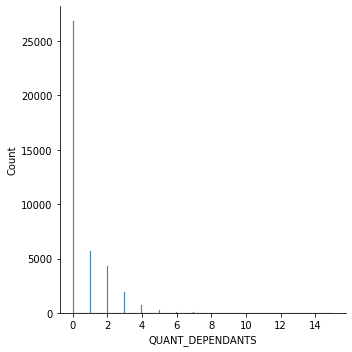

In [ ]:
sns.displot(train['QUANT_DEPENDANTS'])

In [ ]:
train[train['QUANT_DEPENDANTS']>6].shape[0]/train.shape[0]

0.002725

In [ ]:
# let's cut off the quantity of dependants with more than 6 kids.
train=train[train['QUANT_DEPENDANTS']<=6]

In [ ]:
# do the same thing for test data
train=train[train['QUANT_DEPENDANTS']<=6]

MONTHS_IN_RESIDENCE

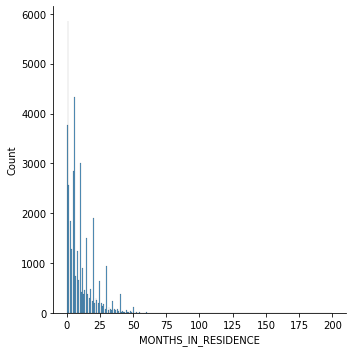

In [ ]:
sns.displot(train['MONTHS_IN_RESIDENCE'])

In [ ]:
train[train['MONTHS_IN_RESIDENCE']>60].shape[0]/train.shape[0]

0.0010528690682108746

In [ ]:
# cut off the MONTHS_IN_RESIDENCE where it is larger than 60
train=train[train['MONTHS_IN_RESIDENCE']<60]

In [ ]:
# do the same operation on test data
test=test[test['MONTHS_IN_RESIDENCE']<60]

PERSONAL_MONTHLY_INCOME

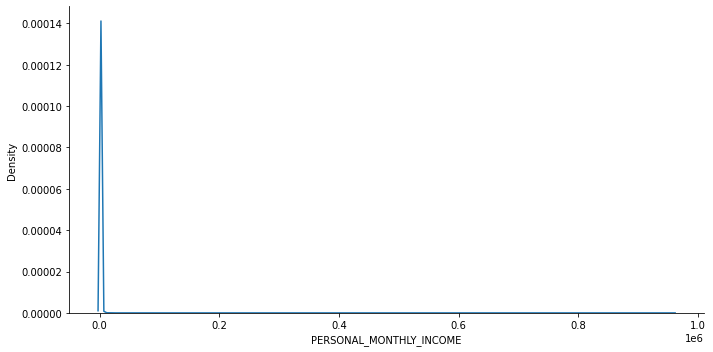

In [ ]:
sns.displot(train['PERSONAL_MONTHLY_INCOME'], kind='kde', height=5, aspect=2)

In [ ]:
# cut off values larger than 10000.
train=train[train['PERSONAL_MONTHLY_INCOME']<10000]

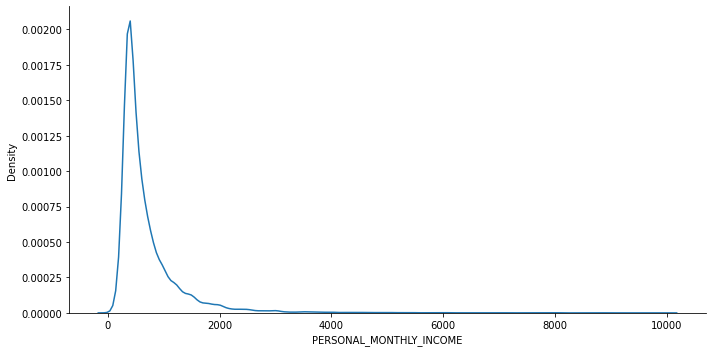

In [ ]:
sns.displot(train['PERSONAL_MONTHLY_INCOME'], kind='kde', height=5, aspect=2)

In [ ]:
# do the same thing on test data
test=test[test['PERSONAL_MONTHLY_INCOME']<10000]

OTHER_INCOMES

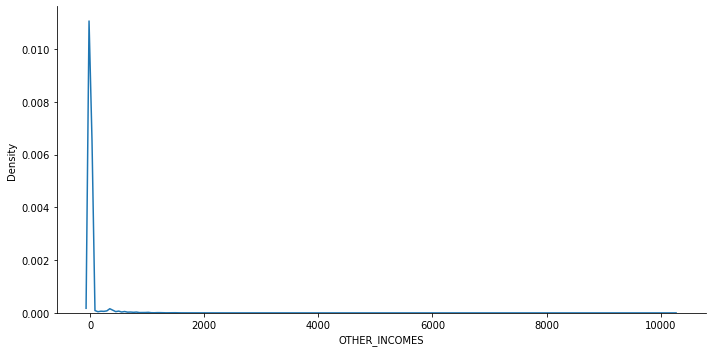

In [ ]:
sns.displot(train['OTHER_INCOMES'], kind='kde', height=5, aspect=2)

In [ ]:
#cut off the value larger than 2000
train=train[train['OTHER_INCOMES']<2000]

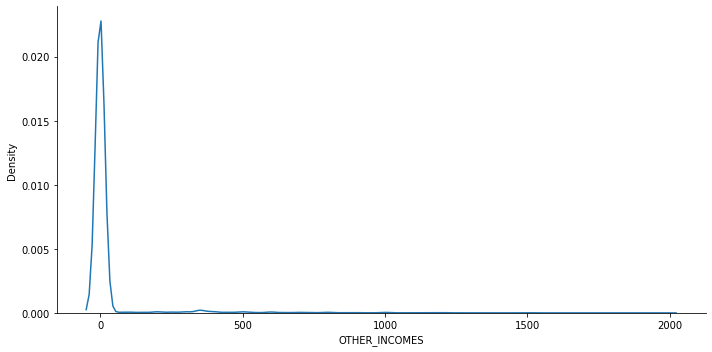

In [ ]:
sns.displot(train['OTHER_INCOMES'], kind='kde', height=5, aspect=2)

In [ ]:
# do the same thing on test data
test=test[test['OTHER_INCOMES']<2000]

PERSONAL_ASSETS_VALUE

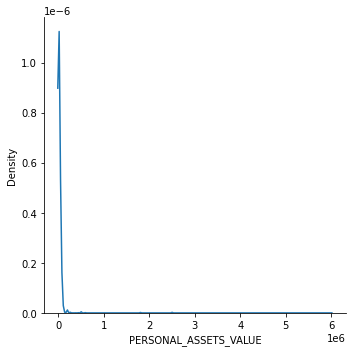

In [ ]:
sns.displot(train['PERSONAL_ASSETS_VALUE'], kind='kde')

In [ ]:
#cut off values larger than 1000000
train=train[train['PERSONAL_ASSETS_VALUE']<100000]

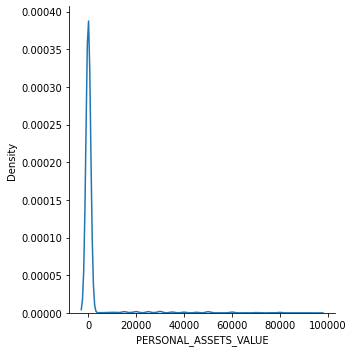

In [ ]:
sns.displot(train['PERSONAL_ASSETS_VALUE'], kind='kde')

In [ ]:
# do the same thing for test data
test=test[test['PERSONAL_ASSETS_VALUE']<100000]

AGE

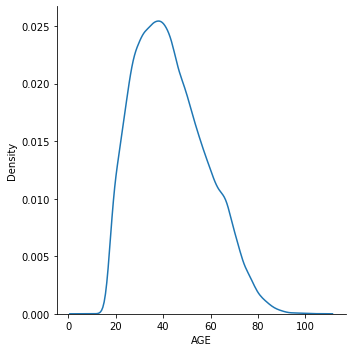

In [ ]:
sns.displot(train['AGE'], kind='kde')

In [ ]:
# let's trim age<15 and age>100 off
train=train[(train['AGE']>15) & (train['AGE']<100)]

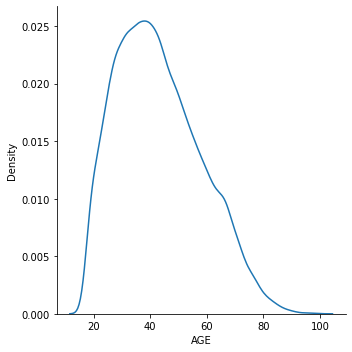

In [ ]:
sns.displot(train['AGE'], kind='kde')

In [ ]:
# do the same operation on test data
test=test[(test['AGE']>15) & (test['AGE']<100)]

## 1.3 Other Operation

CLERK_TYPE

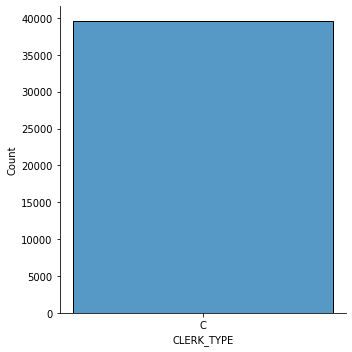

In [ ]:
sns.displot(train['CLERK_TYPE'])

In [ ]:
# only one value in CLERK_TYPE, so this feature can be dropped
train.drop('CLERK_TYPE', axis='columns', inplace=True)
#drop the ID_CLIENT as well
train.drop('ID_CLIENT', axis='columns', inplace=True)

In [ ]:
# do the same operation in test data
test.drop('CLERK_TYPE', axis='columns', inplace=True)
test.drop('ID_CLIENT', axis='columns', inplace=True)

APPLICATION_SUBMISSION_TYPE

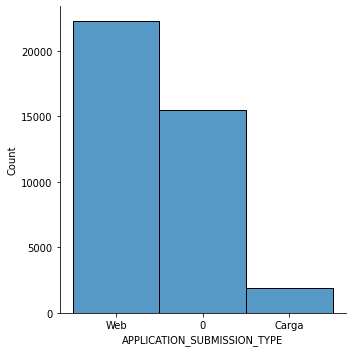

In [ ]:
sns.displot(train['APPLICATION_SUBMISSION_TYPE'])

What does 0 in APPLICATION_SUBMISSION_TYPE mean? Since there is no further information, and from the data description, seems only two values, "web" and "carga". So I use the mode to replace 0

In [ ]:
train['APPLICATION_SUBMISSION_TYPE'].replace('0', 'Web', inplace=True)

In [ ]:
# do the same operation in test data
test['APPLICATION_SUBMISSION_TYPE'].replace('0', 'Web', inplace=True)

QUANT_ADDITIONAL_CARDS

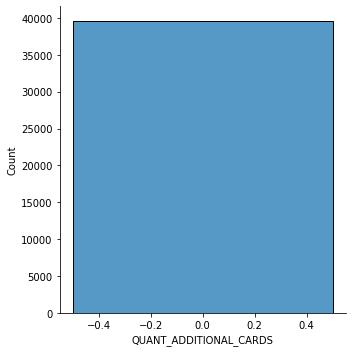

In [ ]:
sns.displot(train['QUANT_ADDITIONAL_CARDS'])

In [ ]:
# Since only one value in QUANT_ADDITIONAL_CARDS, it is not useful in prediction.
train.drop('QUANT_ADDITIONAL_CARDS', axis='columns', inplace=True)

In [ ]:
# do the same operation in test data
test.drop('QUANT_ADDITIONAL_CARDS', axis='columns', inplace=True)

POSTAL_ADDRESS_TYPE

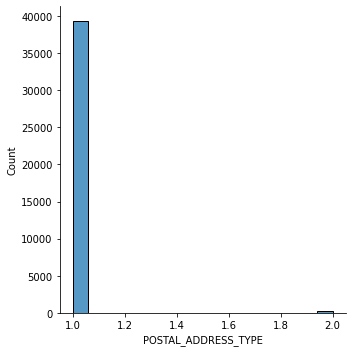

In [ ]:
sns.displot(train['POSTAL_ADDRESS_TYPE'])

In [ ]:
train['POSTAL_ADDRESS_TYPE'].value_counts()

1    39309
2      272
Name: POSTAL_ADDRESS_TYPE, dtype: int64

In [ ]:
# Since the POSTAL_ADDRESS_TYPE==1 takes up to 99.31%, it is safe to assume this feature only has one value, so drop this column
train.drop('POSTAL_ADDRESS_TYPE', axis='columns', inplace=True)

In [ ]:
# do the same operation in test data
test.drop('POSTAL_ADDRESS_TYPE', axis='columns', inplace=True)

MARITAL_STATUS

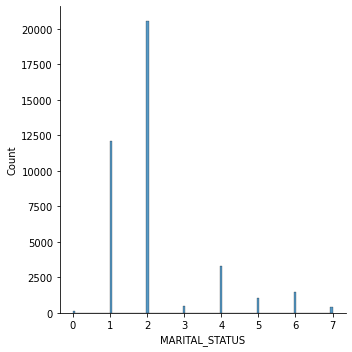

In [ ]:
sns.displot(train['MARITAL_STATUS'])

In [ ]:
# categorize low frequency categories into one category
def mask(x):
  if x==0 or x==3 or x==5 or x==6 or x==7:
    return 3
  else:
    return x
train['MARITAL_STATUS']=train['MARITAL_STATUS'].apply(lambda x: mask(x))

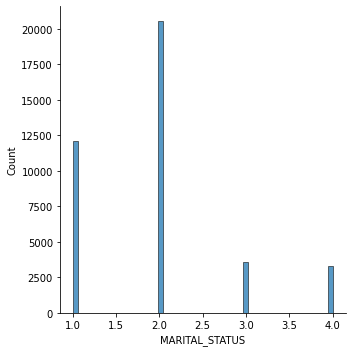

In [ ]:
sns.displot(train['MARITAL_STATUS'])

In [ ]:
# categorize the test data as well
test['MARITAL_STATUS']=test['MARITAL_STATUS'].apply(lambda x: mask(x))

EDUCATION_LEVEL

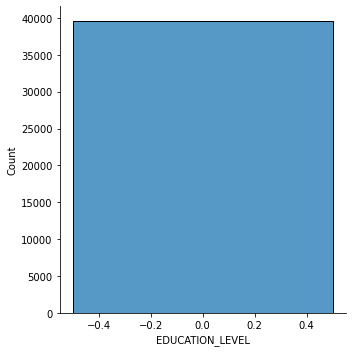

In [ ]:
sns.displot(train['EDUCATION_LEVEL'])

In [ ]:
# Since EDUCATION_LEVEL has only one value, let's drop it.
train.drop('EDUCATION_LEVEL', axis='columns', inplace=True)

In [ ]:
# do the same thing for test data
test.drop('EDUCATION_LEVEL', axis='columns', inplace=True)

RESIDENCE_TYPE

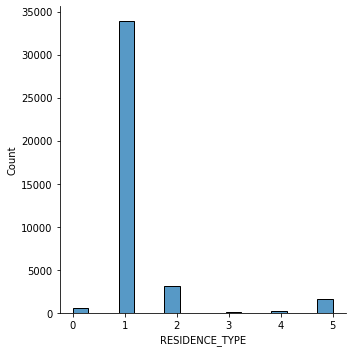

In [ ]:
sns.displot(train['RESIDENCE_TYPE'])

In [ ]:
# categorize low frequency categories into one category
def mask(x):
  if x==0 or x==3 or x==4 or x==5:
    return 0
  else:
    return x
train['RESIDENCE_TYPE']=train['RESIDENCE_TYPE'].apply(lambda x: mask(x))

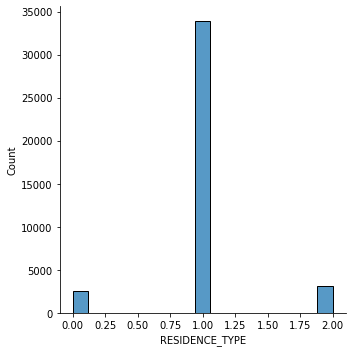

In [ ]:
sns.displot(train['RESIDENCE_TYPE'])

In [ ]:
# do the same operation on test data
test['RESIDENCE_TYPE']=test['RESIDENCE_TYPE'].apply(lambda x: mask(x))

FLAG_MOBILE_PHONE

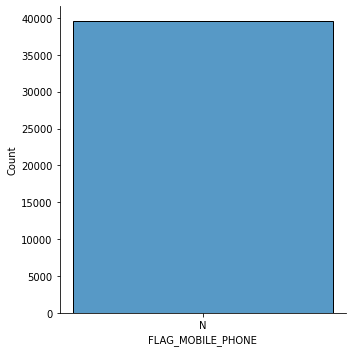

In [ ]:
sns.displot(train['FLAG_MOBILE_PHONE'])

In [ ]:
# Since only one value in FLAG_MOBILE_PHONE, so let's drop it.
train.drop('FLAG_MOBILE_PHONE', axis='columns', inplace=True)

In [ ]:
# do the same operation on test data
test.drop('FLAG_MOBILE_PHONE', axis='columns', inplace=True)

MONTHS_IN_THE_JOB

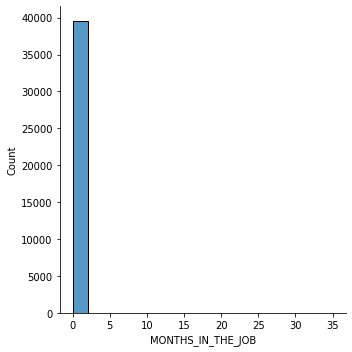

In [ ]:
sns.displot(train['MONTHS_IN_THE_JOB'])

In [ ]:
# categorize low frequency categories into one category
def mask(x):
  if x==0:
    return 0
  else:
    return 1
train['MONTHS_IN_THE_JOB']=train['MONTHS_IN_THE_JOB'].apply(lambda x: mask(x))

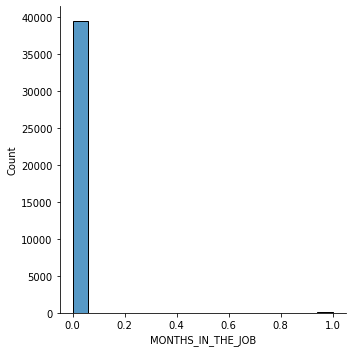

In [ ]:
sns.displot(train['MONTHS_IN_THE_JOB'])

In [ ]:
# do the same operation on test data
test['MONTHS_IN_THE_JOB']=test['MONTHS_IN_THE_JOB'].apply(lambda x: mask(x))

PROFESSION_CODE

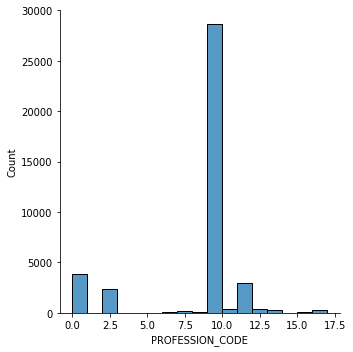

In [ ]:
sns.displot(train['PROFESSION_CODE'])

In [ ]:
# categorize low frequency categories into one category
def mask(x):
  if x==9 or x==0 or x==11 or x==2:
    return x
  else:
    return 1
train['PROFESSION_CODE']=train['PROFESSION_CODE'].apply(lambda x: mask(x))

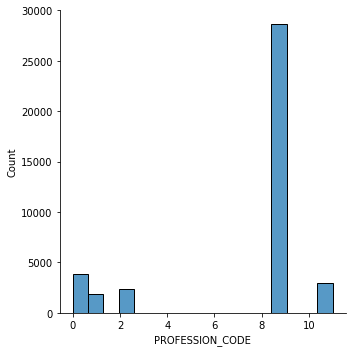

In [ ]:
sns.displot(train['PROFESSION_CODE'])

In [ ]:
# do the same operation for test data
test['PROFESSION_CODE']=test['PROFESSION_CODE'].apply(lambda x: mask(x))

MATE_PROFESSION_CODE

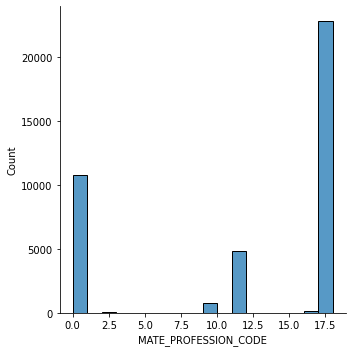

In [ ]:
sns.displot(train['MATE_PROFESSION_CODE'])

In [ ]:
# categorize low frequency categories into one category
def mask(x):
  if x==18 or x==0 or x==11:
    return x
  else:
    return 1
train['MATE_PROFESSION_CODE']=train['MATE_PROFESSION_CODE'].apply(lambda x: mask(x))

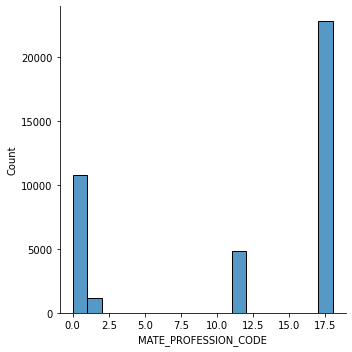

In [ ]:
sns.displot(train['MATE_PROFESSION_CODE'])

In [ ]:
# do the same operation on test data
test['MATE_PROFESSION_CODE']=test['MATE_PROFESSION_CODE'].apply(lambda x: mask(x))

MATE_EDUCATION_LEVEL

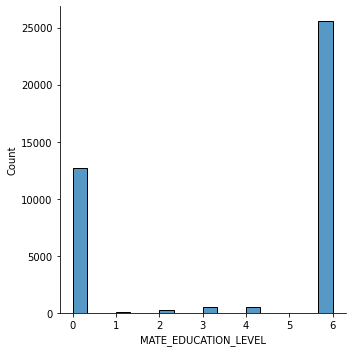

In [ ]:
sns.displot(train['MATE_EDUCATION_LEVEL'])

In [ ]:
# categorize low frequency categories into one category
def mask(x):
  if x==6 or x==0:
    return x
  else:
    return 1
train['MATE_EDUCATION_LEVEL']=train['MATE_EDUCATION_LEVEL'].apply(lambda x: mask(x))

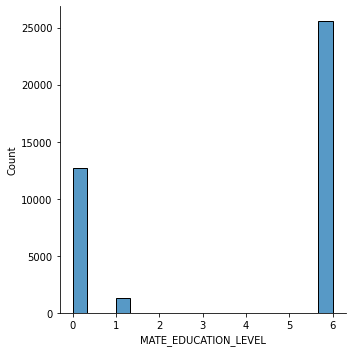

In [ ]:
sns.displot(train['MATE_EDUCATION_LEVEL'])

In [ ]:
# do the same operation on test data
test['MATE_EDUCATION_LEVEL']=test['MATE_EDUCATION_LEVEL'].apply(lambda x: mask(x))

FLAG_HOME_ADDRESS_DOCUMENT

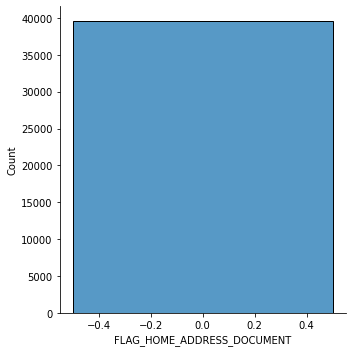

In [ ]:
sns.displot(train['FLAG_HOME_ADDRESS_DOCUMENT'])

In [ ]:
#Since only one value in FLAG_HOME_ADDRESS_DOCUMENT, let's drop it.
train.drop('FLAG_HOME_ADDRESS_DOCUMENT', axis='columns', inplace=True)

In [ ]:
# do the same thing on test data
test.drop('FLAG_HOME_ADDRESS_DOCUMENT', axis='columns', inplace=True)

FLAG_RG

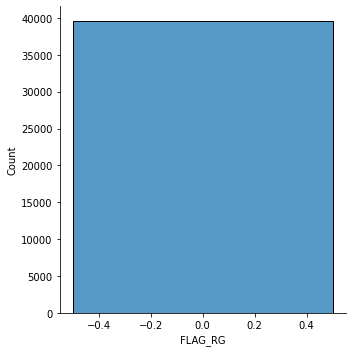

In [ ]:
sns.displot(train['FLAG_RG'])

In [ ]:
# Since only one value in FLAG_RG, let's drop it.
train.drop('FLAG_RG', axis='columns', inplace=True)

In [ ]:
# do the same thing on test data
test.drop('FLAG_RG', axis='columns', inplace=True)

FLAG_CPF

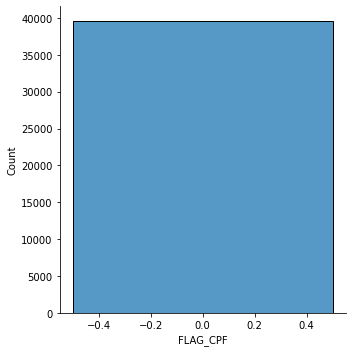

In [ ]:
sns.displot(train['FLAG_CPF'])

In [ ]:
# Since only one value in FLAG_CPF, let's drop it.
train.drop('FLAG_CPF', axis='columns', inplace=True)

In [ ]:
# do the same thing on test data
test.drop('FLAG_CPF', axis='columns', inplace=True)

FLAG_INCOME_PROOF

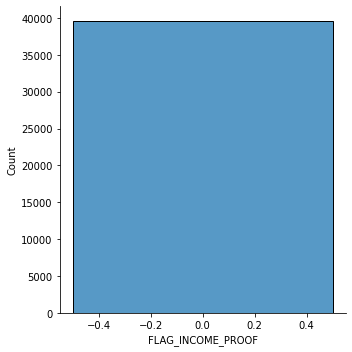

In [ ]:
sns.displot(train['FLAG_INCOME_PROOF'])

In [ ]:
# Since only one value in FLAG_INCOME_PROOF, let's drop it.
train.drop('FLAG_INCOME_PROOF', axis='columns', inplace=True)

In [ ]:
# do the same thing on test data
test.drop('FLAG_INCOME_PROOF', axis='columns', inplace=True)

## 1.3 Wrong Input

One record in RESIDENCIAL_ZIP_3 and PROFESSIONAL_ZIP_3 is not correct format. Let's replace it with the mode

In [ ]:
train[train['RESIDENCIAL_ZIP_3']=='#DIV/0!']

,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,CITY_OF_BIRTH,NACIONALITY,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,FLAG_RESIDENCIAL_PHONE,RESIDENCIAL_PHONE_AREA_CODE,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,COMPANY,PROFESSIONAL_STATE,PROFESSIONAL_CITY,FLAG_PROFESSIONAL_PHONE,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
48923,25,Web,2,0,SP,SAO PAULO,1,SP,Itapecerica da Serra,ibu mirim,Y,5,0.0,10.0,1,400.0,0.0,0,1,0,0,0,0,0,0.0,0,N,SP,Itapecerica da Serra,Y,0,9.0,5.0,18.0,6.0,1,N,25,#DIV/0!,#DIV/0!,0


In [ ]:
train['PROFESSIONAL_ZIP_3'].replace('#DIV/0!', train['PROFESSIONAL_ZIP_3'].mode()[0], inplace=True)
train['RESIDENCIAL_ZIP_3'].replace('#DIV/0!', train['RESIDENCIAL_ZIP_3'].mode()[0], inplace=True)

## 1.4 Normality

In [ ]:
from scipy.stats import zscore

In [ ]:
# Identify the numerical columns
numeric_cols = train.select_dtypes(include=[np.number]).columns
numeric_cols 

Index(['PAYMENT_DAY', 'MARITAL_STATUS', 'QUANT_DEPENDANTS', 'NACIONALITY',
       'RESIDENCE_TYPE', 'MONTHS_IN_RESIDENCE', 'FLAG_EMAIL',
       'PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES', 'FLAG_VISA',
       'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS',
       'FLAG_OTHER_CARDS', 'QUANT_BANKING_ACCOUNTS',
       'QUANT_SPECIAL_BANKING_ACCOUNTS', 'PERSONAL_ASSETS_VALUE', 'QUANT_CARS',
       'MONTHS_IN_THE_JOB', 'PROFESSION_CODE', 'OCCUPATION_TYPE',
       'MATE_PROFESSION_CODE', 'MATE_EDUCATION_LEVEL', 'PRODUCT', 'AGE',
       'TARGET_LABEL_BAD=1'],
      dtype='object')

In [ ]:
# reomve the encoded categorical variables 'PAYMENT_DAY', 'MARITAL_STATUS', 'NACIONALITY', 'RESIDENCE_TYPE', FLAG_EMAIL', 'FLAG_VISA',
# 'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_OTHER_CARDS', 'MONTHS_IN_THE_JOB', 'PROFESSION_CODE', 'OCCUPATION_TYPE',
# 'MATE_PROFESSION_CODE', 'MATE_EDUCATION_LEVEL', 'PRODUCT', 'TARGET_LABEL_BAD=1'
numeric_cols=numeric_cols[np.r_[2, 5, 7, 8, 14:18, 24]]
numeric_cols

Index(['QUANT_DEPENDANTS', 'MONTHS_IN_RESIDENCE', 'PERSONAL_MONTHLY_INCOME',
       'OTHER_INCOMES', 'QUANT_BANKING_ACCOUNTS',
       'QUANT_SPECIAL_BANKING_ACCOUNTS', 'PERSONAL_ASSETS_VALUE', 'QUANT_CARS',
       'AGE'],
      dtype='object')

In [ ]:
train_copy=train.copy()
train_copy[numeric_cols]=train_copy[numeric_cols].apply(zscore)

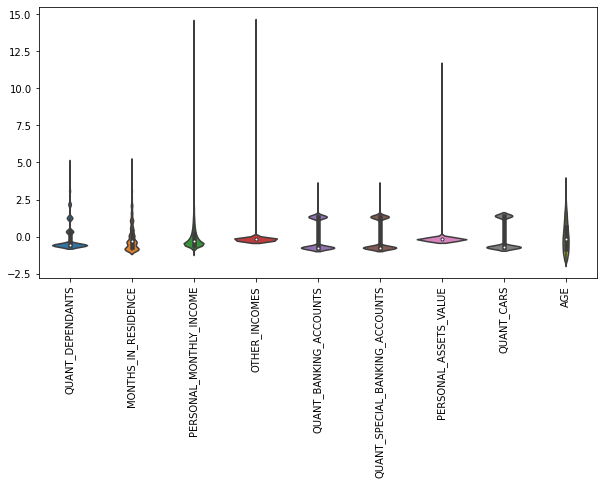

In [ ]:
fig, ax=plt.subplots(figsize=(10, 5))
a= sns.violinplot(data=train_copy[numeric_cols], ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

In [ ]:
# save the clean dataset
train.to_pickle('trainClean.pkl')
test.to_pickle('testClean.pkl')

## 1.5 New variables

In [ ]:
# Let's combine the PERSONAL_MONTHLY_INCOME, OTHER_INCOMES into a new variable TOTAL_INCOMES
train['TOTAL_INCOMES']=train['PERSONAL_MONTHLY_INCOME']+train['OTHER_INCOMES']

In [ ]:
# create a new variable FLAG_CARDS by combing 'FLAG_VISA', 'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS' and 'FLAG_OTHER_CARDS' together.
train['FLAG_CARDS']=train['FLAG_VISA']+train['FLAG_MASTERCARD']+train['FLAG_DINERS']+train['FLAG_AMERICAN_EXPRESS']+train['FLAG_OTHER_CARDS']

In [ ]:
# creat a new variable QUANT_ALL_BANKING_ACCOUNTS by combining 'QUANT_BANKING_ACCOUNTS' and 'QUANT_SPECIAL_BANKING_ACCOUNTS' together
train['QUANT_ALL_BANKING_ACCOUNTS']=train['QUANT_BANKING_ACCOUNTS']+train['QUANT_SPECIAL_BANKING_ACCOUNTS']

In [ ]:
#create a new variable AVG_INCOME_STATE for the average personal income per residential state.
train['AVG_INCOME_STATE']=train.groupby('RESIDENCIAL_STATE')['PERSONAL_MONTHLY_INCOME'].transform('mean')

In [ ]:
#creat a new variable AVG_INCOME_OCCUPATION_TYPE for the average personal income per occupation_type
train['AVG_INCOME_OCCUPATION_TYPE']=train.groupby('OCCUPATION_TYPE')['PERSONAL_MONTHLY_INCOME'].transform('mean')

In [ ]:
#creat a new variable AVG_INCOME_PROFESSION_CODE for the average personal income per profession code
train['AVG_INCOME_PROFESSION_CODE']=train.groupby('PROFESSION_CODE')['PERSONAL_MONTHLY_INCOME'].transform('mean')

In [ ]:
#creat the same varibles on test data
test['TOTAL_INCOMES']=test['PERSONAL_MONTHLY_INCOME']+test['OTHER_INCOMES']
test['FLAG_CARDS']=test['FLAG_VISA']+test['FLAG_MASTERCARD']+test['FLAG_DINERS']+test['FLAG_AMERICAN_EXPRESS']+test['FLAG_OTHER_CARDS']
test['QUANT_ALL_BANKING_ACCOUNTS']=test['QUANT_BANKING_ACCOUNTS']+test['QUANT_SPECIAL_BANKING_ACCOUNTS']
test['AVG_INCOME_STATE']=test.groupby('RESIDENCIAL_STATE')['PERSONAL_MONTHLY_INCOME'].transform('mean')
test['AVG_INCOME_OCCUPATION_TYPE']=test.groupby('OCCUPATION_TYPE')['PERSONAL_MONTHLY_INCOME'].transform('mean')
test['AVG_INCOME_PROFESSION_CODE']=test.groupby('PROFESSION_CODE')['PERSONAL_MONTHLY_INCOME'].transform('mean')

In [ ]:
# save the clean dataset with new variables
train.to_pickle('trainCleanNewVariable.pkl')
test.to_pickle('testCleanNewVariable.pkl')

# 2. WOE and IV

## 2.1 Binning

In [ ]:
train=train.drop(['CITY_OF_BIRTH', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'RESIDENCIAL_PHONE_AREA_CODE', 'PROFESSIONAL_CITY', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3'], axis='columns')

In [ ]:
#somehow MONTHS_IN_THE_JOB will report an error,
train.drop('MONTHS_IN_THE_JOB', axis="columns", inplace=True)

In [ ]:
train.drop('FLAG_AMERICAN_EXPRESS', axis="columns", inplace=True)

In [ ]:
train.drop('PERSONAL_ASSETS_VALUE', axis="columns", inplace=True)

In [ ]:
train.drop('FLAG_DINERS', axis="columns", inplace=True)
train.drop('FLAG_VISA', axis="columns", inplace=True)
train.drop('FLAG_MASTERCARD', axis="columns", inplace=True)
train.drop('FLAG_OTHER_CARDS', axis="columns", inplace=True)

In [ ]:
train.drop('NACIONALITY', axis="columns", inplace=True)

In [ ]:
# drop the same columns on test data
test=test.drop(['CITY_OF_BIRTH', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'RESIDENCIAL_PHONE_AREA_CODE', 'PROFESSIONAL_CITY', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3'], axis='columns')
test.drop('MONTHS_IN_THE_JOB', axis="columns", inplace=True)
test.drop('FLAG_AMERICAN_EXPRESS', axis="columns", inplace=True)
test.drop('PERSONAL_ASSETS_VALUE', axis="columns", inplace=True)
test.drop('FLAG_DINERS', axis="columns", inplace=True)
test.drop('FLAG_VISA', axis="columns", inplace=True)
test.drop('FLAG_MASTERCARD', axis="columns", inplace=True)
test.drop('FLAG_OTHER_CARDS', axis="columns", inplace=True)
test.drop('NACIONALITY', axis="columns", inplace=True)

In [ ]:
# save the clean dataset with new variables
train.to_pickle('trainCleanNewVariable_noWoE.pkl')
test.to_pickle('testCleanNewVariable_noWoE.pkl')

In [ ]:
bins=sc.woebin(train, y='TARGET_LABEL_BAD=1', 
               min_perc_fine_bin=0.01, # How many bins to cut initially into
               min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
               stop_limit=0.02, # Minimum information value 
               max_num_bin=8, # Maximum number of bins
               method='tree'               
               )

[INFO] creating woe binning ...


/usr/local/lib/python3.7/dist-packages/scorecardpy/condition_fun.py:19: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: FLAG_ACSP_RECORD)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))


Binning on 39581 rows and 31 columns in 00:00:28


/usr/local/lib/python3.7/dist-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/usr/local/lib/python3.7/dist-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/usr/local/lib/python3.7/dist-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To co

{'AGE': <Figure size 432x288 with 2 Axes>,
 'APPLICATION_SUBMISSION_TYPE': <Figure size 432x288 with 2 Axes>,
 'AVG_INCOME_OCCUPATION_TYPE': <Figure size 432x288 with 2 Axes>,
 'AVG_INCOME_PROFESSION_CODE': <Figure size 432x288 with 2 Axes>,
 'AVG_INCOME_STATE': <Figure size 432x288 with 2 Axes>,
 'COMPANY': <Figure size 432x288 with 2 Axes>,
 'FLAG_CARDS': <Figure size 432x288 with 2 Axes>,
 'FLAG_EMAIL': <Figure size 432x288 with 2 Axes>,
 'FLAG_PROFESSIONAL_PHONE': <Figure size 432x288 with 2 Axes>,
 'FLAG_RESIDENCIAL_PHONE': <Figure size 432x288 with 2 Axes>,
 'MARITAL_STATUS': <Figure size 432x288 with 2 Axes>,
 'MATE_EDUCATION_LEVEL': <Figure size 432x288 with 2 Axes>,
 'MATE_PROFESSION_CODE': <Figure size 432x288 with 2 Axes>,
 'MONTHS_IN_RESIDENCE': <Figure size 432x288 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 432x288 with 2 Axes>,
 'OTHER_INCOMES': <Figure size 432x288 with 2 Axes>,
 'PAYMENT_DAY': <Figure size 432x288 with 2 Axes>,
 'PERSONAL_MONTHLY_INCOME': <Figure si

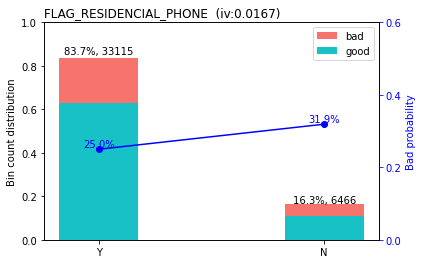

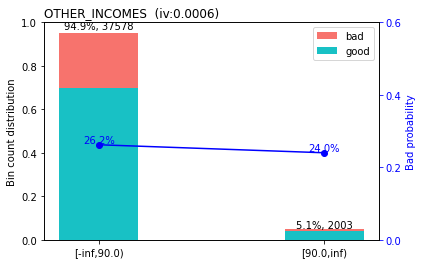

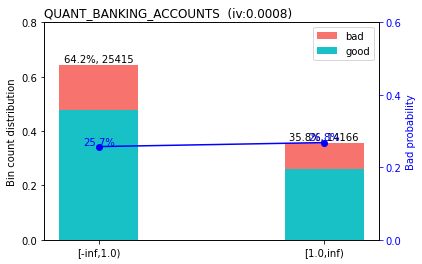

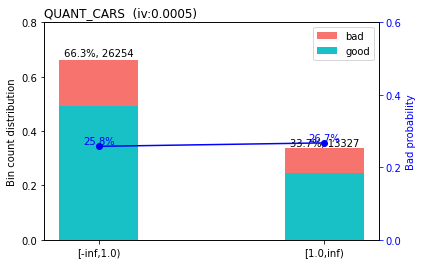

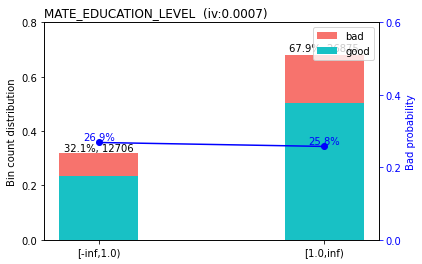

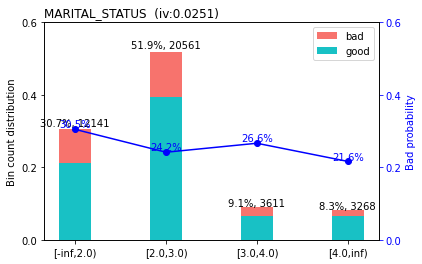

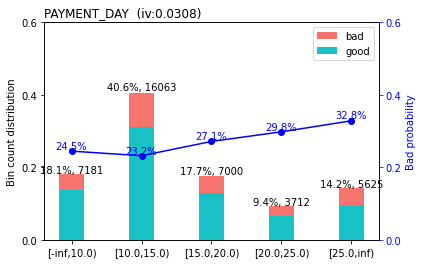

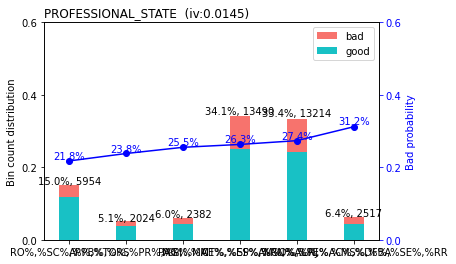

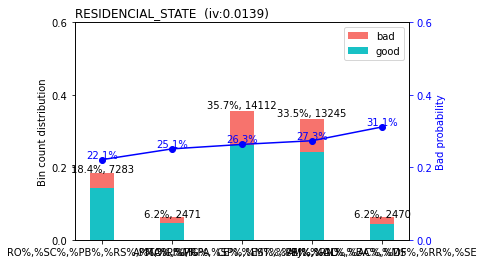

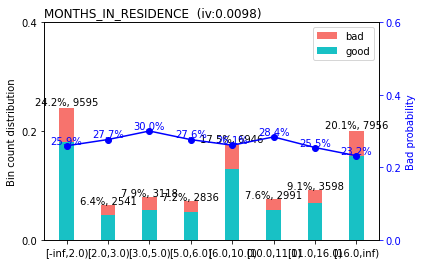

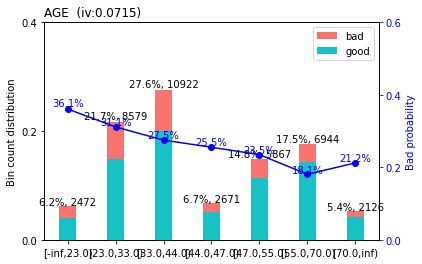

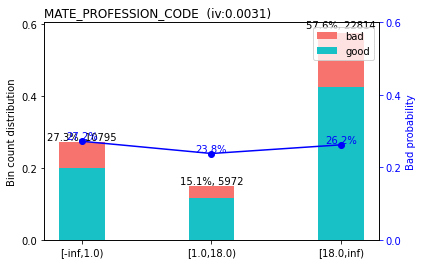

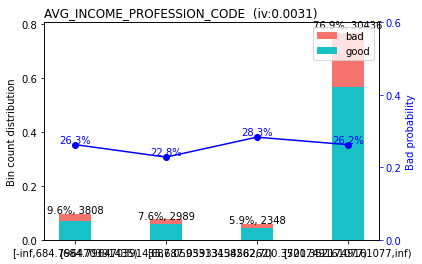

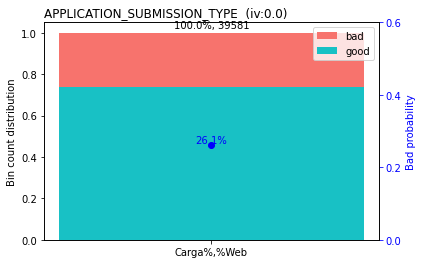

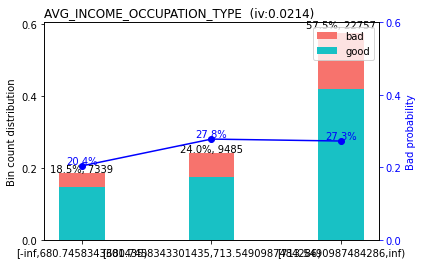

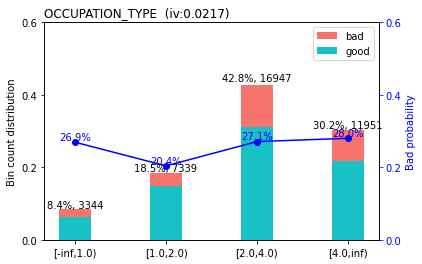

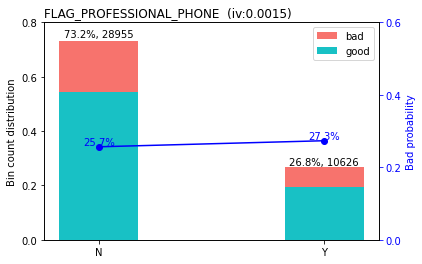

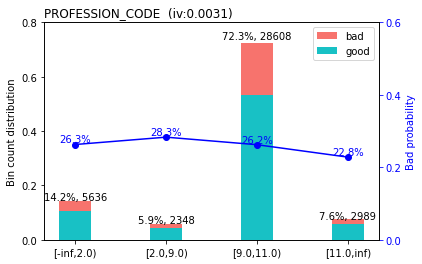

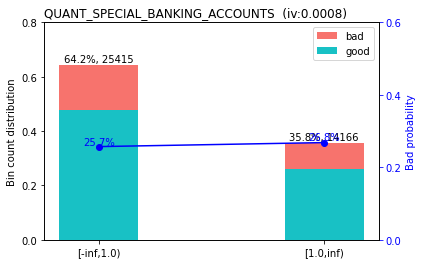

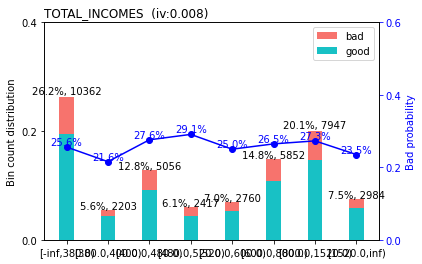

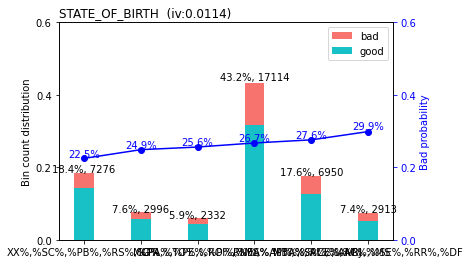

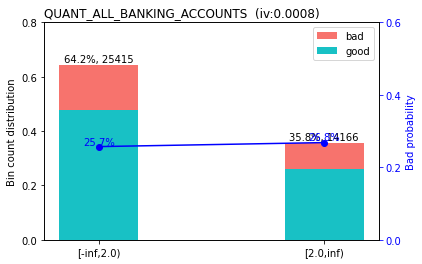

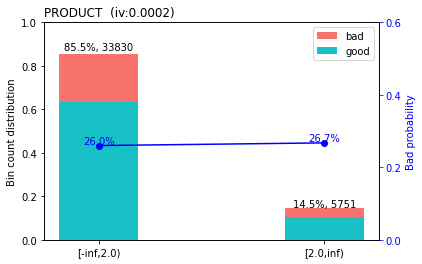

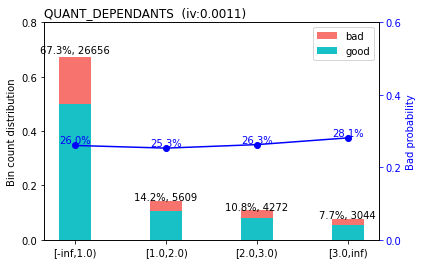

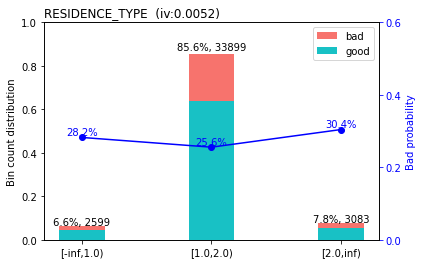

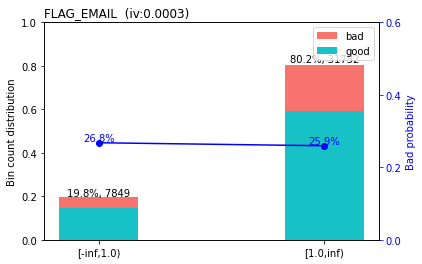

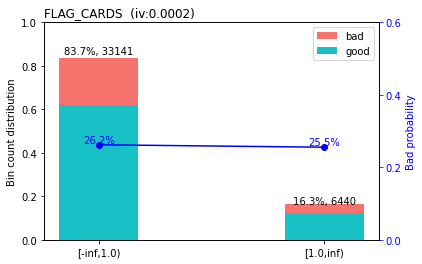

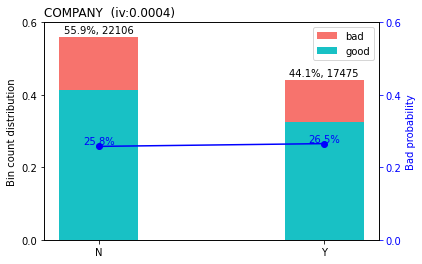

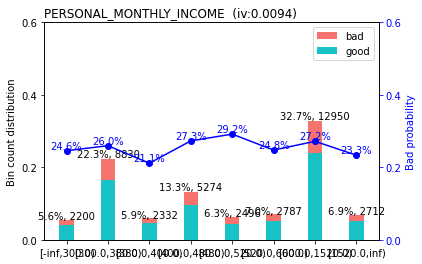

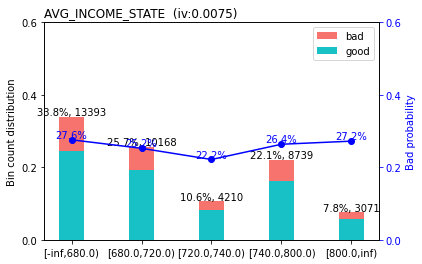

In [ ]:
sc.woebin_plot(bins)

## 2.2 Manual adjustment

-------- 1/30 FLAG_RESIDENCIAL_PHONE --------
>>> dt[FLAG_RESIDENCIAL_PHONE].describe(): 
count     39581
unique        2
top           Y
freq      33115
Name: FLAG_RESIDENCIAL_PHONE, dtype: object 

>>> dt[FLAG_RESIDENCIAL_PHONE].value_counts(): 
Y    33115
N     6466
Name: FLAG_RESIDENCIAL_PHONE, dtype: int64 

>>> Current breaks:
'Y','N' 



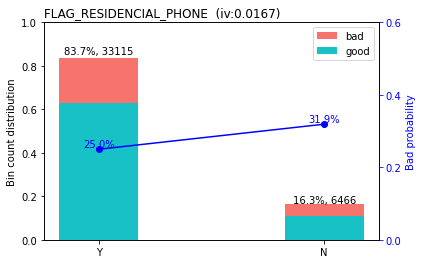

>>> Adjust breaks for (1/30) FLAG_RESIDENCIAL_PHONE?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/30 OTHER_INCOMES --------
>>> dt[OTHER_INCOMES].describe(): 
count    39581.000000
mean        25.924674
std        134.864605
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1973.240000
Name: OTHER_INCOMES, dtype: float64 



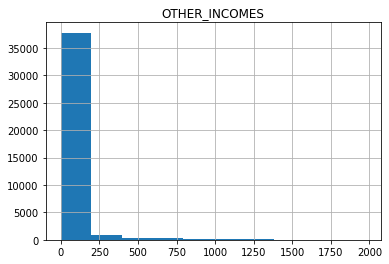

>>> Current breaks:
90.0 



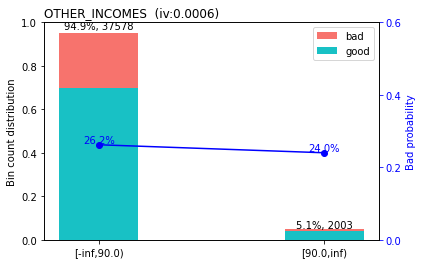

>>> Adjust breaks for (2/30) OTHER_INCOMES?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/30 QUANT_BANKING_ACCOUNTS --------
>>> dt[QUANT_BANKING_ACCOUNTS].describe(): 
count    39581.000000
mean         0.358202
std          0.480110
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: QUANT_BANKING_ACCOUNTS, dtype: float64 

>>> dt[QUANT_BANKING_ACCOUNTS].value_counts(): 
0    25415
1    14154
2       12
Name: QUANT_BANKING_ACCOUNTS, dtype: int64 

>>> Current breaks:
1.0 



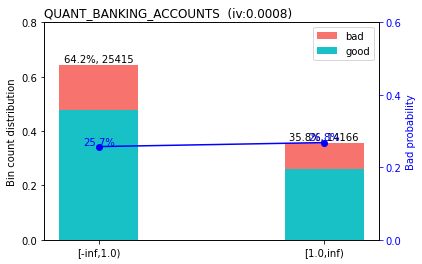

>>> Adjust breaks for (3/30) QUANT_BANKING_ACCOUNTS?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/30 QUANT_CARS --------
>>> dt[QUANT_CARS].describe(): 
count    39581.000000
mean         0.336702
std          0.472588
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: QUANT_CARS, dtype: float64 

>>> dt[QUANT_CARS].value_counts(): 
0    26254
1    13327
Name: QUANT_CARS, dtype: int64 

>>> Current breaks:
1.0 



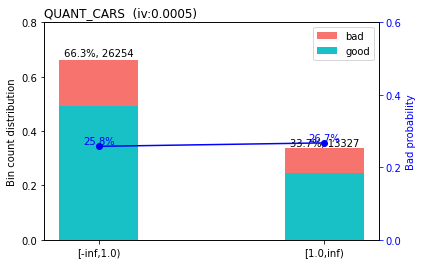

>>> Adjust breaks for (4/30) QUANT_CARS?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/30 MATE_EDUCATION_LEVEL --------
>>> dt[MATE_EDUCATION_LEVEL].describe(): 
count    39581.000000
mean         3.910336
std          2.829824
min          0.000000
25%          0.000000
50%          6.000000
75%          6.000000
max          6.000000
Name: MATE_EDUCATION_LEVEL, dtype: float64 

>>> dt[MATE_EDUCATION_LEVEL].value_counts(): 
6.0    25580
0.0    12706
1.0     1295
Name: MATE_EDUCATION_LEVEL, dtype: int64 

>>> Current breaks:
1.0 



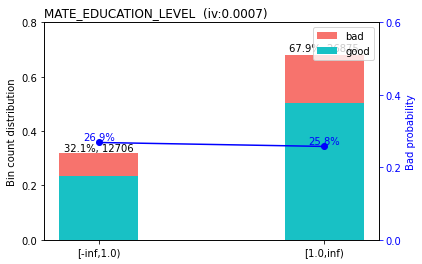

>>> Adjust breaks for (5/30) MATE_EDUCATION_LEVEL?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/30 MARITAL_STATUS --------
>>> dt[MARITAL_STATUS].describe(): 
count    39581.000000
mean         1.949622
std          0.851885
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: MARITAL_STATUS, dtype: float64 

>>> dt[MARITAL_STATUS].value_counts(): 
2    20561
1    12141
3     3611
4     3268
Name: MARITAL_STATUS, dtype: int64 

>>> Current breaks:
2.0,3.0,4.0 



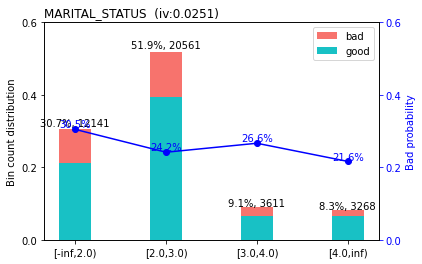

>>> Adjust breaks for (6/30) MARITAL_STATUS?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/30 PAYMENT_DAY --------
>>> dt[PAYMENT_DAY].describe(): 
count    39581.000000
mean        12.907001
std          6.619403
min          1.000000
25%         10.000000
50%         10.000000
75%         15.000000
max         25.000000
Name: PAYMENT_DAY, dtype: float64 

>>> dt[PAYMENT_DAY].value_counts(): 
10    16063
15     7000
5      5799
25     5625
20     3712
1      1382
Name: PAYMENT_DAY, dtype: int64 

>>> Current breaks:
10.0,15.0,20.0,25.0 



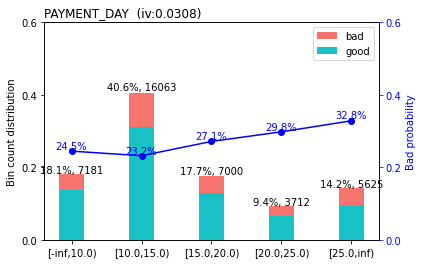

>>> Adjust breaks for (7/30) PAYMENT_DAY?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/30 PROFESSIONAL_STATE --------
>>> dt[PROFESSIONAL_STATE].describe(): 
count     39581
unique       27
top          SP
freq       7014
Name: PROFESSIONAL_STATE, dtype: object 

>>> dt[PROFESSIONAL_STATE].value_counts(): 
SP    7014
RS    4105
BA    3966
CE    3627
PE    2921
MG    2439
PA    1789
RJ    1735
RN    1583
GO    1285
PR    1228
AL    1169
PB    1060
MT    1017
MA     593
MS     571
DF     570
ES     546
SC     497
AP     372
PI     322
AM     321
RO     292
SE     228
AC     176
TO     102
RR      53
Name: PROFESSIONAL_STATE, dtype: int64 

>>> Current breaks:
'RO%,%SC%,%PB%,%RS','AP%,%TO%,%PR%,%PI','PA%,%MA','MG%,%MT%,%SP%,%GO%,%RJ','CE%,%ES%,%RN%,%PE%,%MS%,%BA','AM%,%AL%,%AC%,%DF%,%SE%,%RR' 



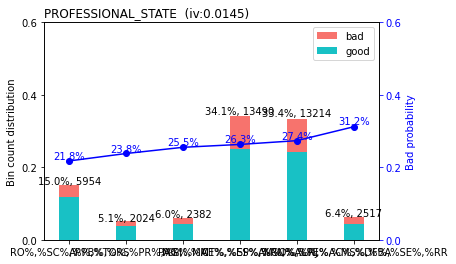

>>> Adjust breaks for (8/30) PROFESSIONAL_STATE?
1: next 
2: yes 
3: back
Selection: 1
-------- 9/30 RESIDENCIAL_STATE --------
>>> dt[RESIDENCIAL_STATE].describe(): 
count     39581
unique       27
top          SP
freq       7009
Name: RESIDENCIAL_STATE, dtype: object 

>>> dt[RESIDENCIAL_STATE].value_counts(): 
SP    7009
RS    4109
BA    3986
CE    3633
PE    2921
MG    2431
PA    1778
RJ    1730
RN    1593
GO    1322
PR    1225
AL    1169
PB    1061
MT    1017
MA     603
MS     569
ES     543
DF     532
SC     494
AP     380
AM     320
PI     313
RO     293
SE     225
AC     173
TO     101
RR      51
Name: RESIDENCIAL_STATE, dtype: int64 

>>> Current breaks:
'RO%,%SC%,%PB%,%RS%,%TO%,%PR','AP%,%PI%,%PA','MA%,%MG%,%SP%,%MT%,%RJ%,%GO','CE%,%ES%,%PE%,%RN%,%BA%,%MS','AM%,%AL%,%AC%,%DF%,%RR%,%SE' 



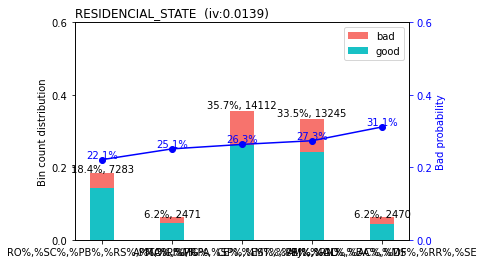

>>> Adjust breaks for (9/30) RESIDENCIAL_STATE?
1: next 
2: yes 
3: back
Selection: 1
-------- 10/30 MONTHS_IN_RESIDENCE --------
>>> dt[MONTHS_IN_RESIDENCE].describe(): 
count    39581.000000
mean         9.259392
std          9.878614
min          0.000000
25%          2.000000
50%          6.000000
75%         13.000000
max         59.000000
Name: MONTHS_IN_RESIDENCE, dtype: float64 



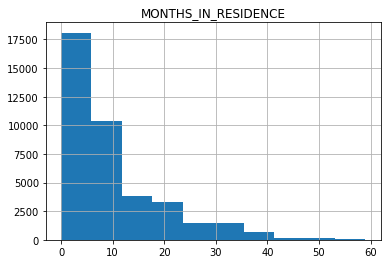

>>> Current breaks:
2.0,3.0,5.0,6.0,10.0,11.0,16.0 



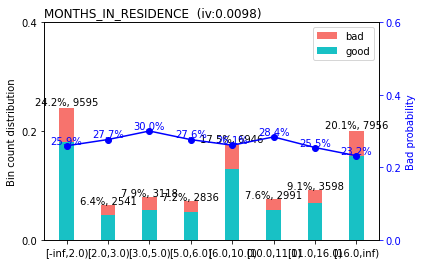

>>> Adjust breaks for (10/30) MONTHS_IN_RESIDENCE?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 6.0,11.0,16.0
[INFO] creating woe binning ...
>>> Current breaks:
16.0, 11.0, 6.0 



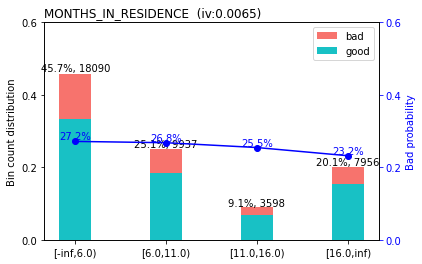

>>> Adjust breaks for (10/30) MONTHS_IN_RESIDENCE?
1: next 
2: yes 
3: back
Selection: 1
-------- 11/30 AGE --------
>>> dt[AGE].describe(): 
count    39581.000000
mean        43.067254
std         14.906897
min         17.000000
25%         31.000000
50%         41.000000
75%         53.000000
max         99.000000
Name: AGE, dtype: float64 



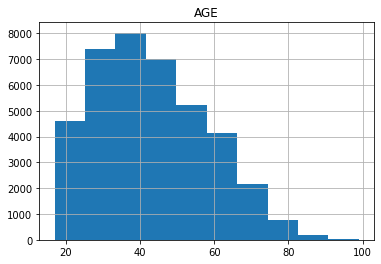

>>> Current breaks:
23.0,33.0,44.0,47.0,55.0,70.0 



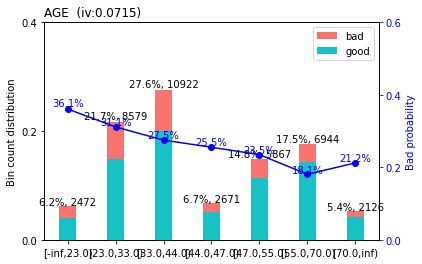

>>> Adjust breaks for (11/30) AGE?
1: next 
2: yes 
3: back
Selection: 1
-------- 12/30 MATE_PROFESSION_CODE --------
>>> dt[MATE_PROFESSION_CODE].describe(): 
count    39581.000000
mean        11.744625
std          7.974401
min          0.000000
25%          0.000000
50%         18.000000
75%         18.000000
max         18.000000
Name: MATE_PROFESSION_CODE, dtype: float64 

>>> dt[MATE_PROFESSION_CODE].value_counts(): 
18.0    22814
0.0     10795
11.0     4824
1.0      1148
Name: MATE_PROFESSION_CODE, dtype: int64 

>>> Current breaks:
1.0,18.0 



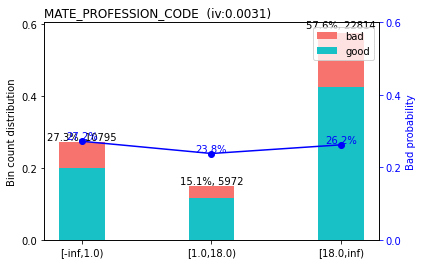

>>> Adjust breaks for (12/30) MATE_PROFESSION_CODE?
1: next 
2: yes 
3: back
Selection: 1
-------- 13/30 AVG_INCOME_PROFESSION_CODE --------
>>> dt[AVG_INCOME_PROFESSION_CODE].describe(): 
count    39581.000000
mean       705.446446
std         43.844008
min        677.172240
25%        700.352175
50%        700.352175
75%        700.352175
max        901.453441
Name: AVG_INCOME_PROFESSION_CODE, dtype: float64 

>>> dt[AVG_INCOME_PROFESSION_CODE].value_counts(): 
700.352175    28608
677.172240     3808
684.796470     2989
687.059331     2348
901.453441     1828
Name: AVG_INCOME_PROFESSION_CODE, dtype: int64 

>>> Current breaks:
684.796470391435,687.0593313458262,700.3521749161077 



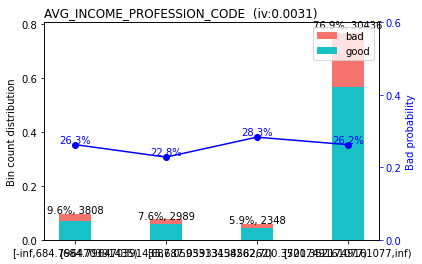

>>> Adjust breaks for (13/30) AVG_INCOME_PROFESSION_CODE?
1: next 
2: yes 
3: back
Selection: 1
-------- 14/30 APPLICATION_SUBMISSION_TYPE --------
>>> dt[APPLICATION_SUBMISSION_TYPE].describe(): 
count     39581
unique        2
top         Web
freq      37717
Name: APPLICATION_SUBMISSION_TYPE, dtype: object 

>>> dt[APPLICATION_SUBMISSION_TYPE].value_counts(): 
Web      37717
Carga     1864
Name: APPLICATION_SUBMISSION_TYPE, dtype: int64 

>>> Current breaks:
'Carga%,%Web' 



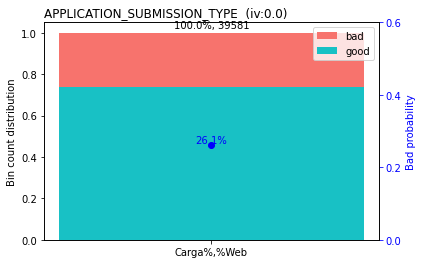

>>> Adjust breaks for (14/30) APPLICATION_SUBMISSION_TYPE?
1: next 
2: yes 
3: back
Selection: 1
-------- 15/30 AVG_INCOME_OCCUPATION_TYPE --------
>>> dt[AVG_INCOME_OCCUPATION_TYPE].describe(): 
count    39581.000000
mean       705.446446
std         23.862934
min        673.957186
25%        680.745834
50%        713.549099
75%        713.549099
max        834.513911
Name: AVG_INCOME_OCCUPATION_TYPE, dtype: float64 

>>> dt[AVG_INCOME_OCCUPATION_TYPE].value_counts(): 
713.549099    16699
673.957186     7339
695.539871     6141
741.112513     5810
680.745834     3344
834.513911      248
Name: AVG_INCOME_OCCUPATION_TYPE, dtype: int64 

>>> Current breaks:
680.7458343301435,713.5490987484286 



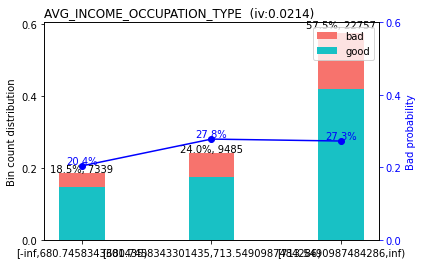

>>> Adjust breaks for (15/30) AVG_INCOME_OCCUPATION_TYPE?
1: next 
2: yes 
3: back
Selection: 1
-------- 16/30 OCCUPATION_TYPE --------
>>> dt[OCCUPATION_TYPE].describe(): 
count    39581.000000
mean         2.402542
std          1.519648
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: OCCUPATION_TYPE, dtype: float64 

>>> dt[OCCUPATION_TYPE].value_counts(): 
2.0    16699
1.0     7339
4.0     6141
5.0     5810
0.0     3344
3.0      248
Name: OCCUPATION_TYPE, dtype: int64 

>>> Current breaks:
1.0,2.0,4.0 



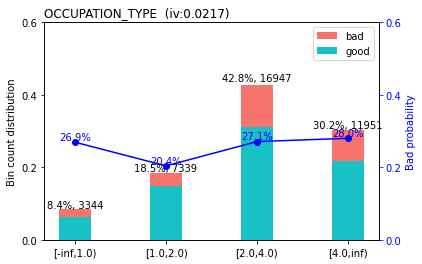

>>> Adjust breaks for (16/30) OCCUPATION_TYPE?
1: next 
2: yes 
3: back
Selection: 1
-------- 17/30 FLAG_PROFESSIONAL_PHONE --------
>>> dt[FLAG_PROFESSIONAL_PHONE].describe(): 
count     39581
unique        2
top           N
freq      28955
Name: FLAG_PROFESSIONAL_PHONE, dtype: object 

>>> dt[FLAG_PROFESSIONAL_PHONE].value_counts(): 
N    28955
Y    10626
Name: FLAG_PROFESSIONAL_PHONE, dtype: int64 

>>> Current breaks:
'N','Y' 



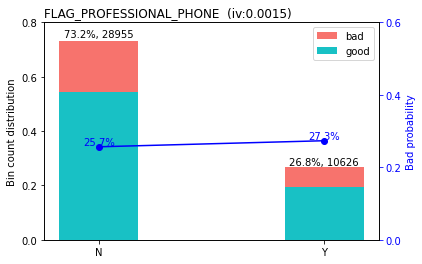

>>> Adjust breaks for (17/30) FLAG_PROFESSIONAL_PHONE?
1: next 
2: yes 
3: back
Selection: 1
-------- 18/30 PROFESSION_CODE --------
>>> dt[PROFESSION_CODE].describe(): 
count    39581.000000
mean         7.500442
std          3.421845
min          0.000000
25%          9.000000
50%          9.000000
75%          9.000000
max         11.000000
Name: PROFESSION_CODE, dtype: float64 

>>> dt[PROFESSION_CODE].value_counts(): 
9.0     28608
0.0      3808
11.0     2989
2.0      2348
1.0      1828
Name: PROFESSION_CODE, dtype: int64 

>>> Current breaks:
2.0,9.0,11.0 



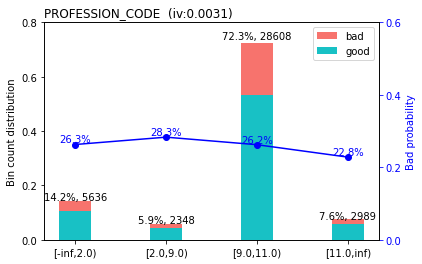

>>> Adjust breaks for (18/30) PROFESSION_CODE?
1: next 
2: yes 
3: back
Selection: 1
-------- 19/30 QUANT_SPECIAL_BANKING_ACCOUNTS --------
>>> dt[QUANT_SPECIAL_BANKING_ACCOUNTS].describe(): 
count    39581.000000
mean         0.358202
std          0.480110
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: QUANT_SPECIAL_BANKING_ACCOUNTS, dtype: float64 

>>> dt[QUANT_SPECIAL_BANKING_ACCOUNTS].value_counts(): 
0    25415
1    14154
2       12
Name: QUANT_SPECIAL_BANKING_ACCOUNTS, dtype: int64 

>>> Current breaks:
1.0 



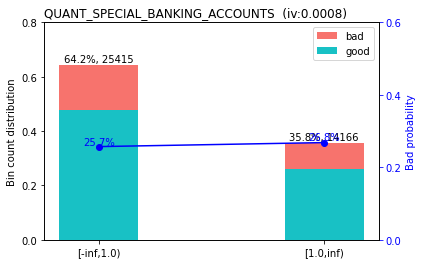

>>> Adjust breaks for (19/30) QUANT_SPECIAL_BANKING_ACCOUNTS?
1: next 
2: yes 
3: back
Selection: 1
-------- 20/30 TOTAL_INCOMES --------
>>> dt[TOTAL_INCOMES].describe(): 
count    39581.000000
mean       731.371120
std        656.748625
min         60.000000
25%        371.000000
50%        511.000000
75%        830.000000
max       9944.000000
Name: TOTAL_INCOMES, dtype: float64 



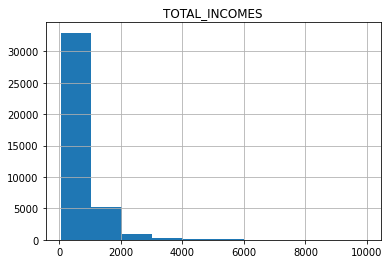

>>> Current breaks:
380.0,400.0,480.0,520.0,600.0,800.0,1520.0 



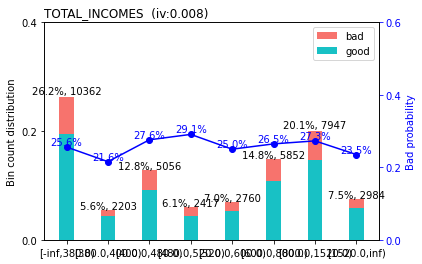

>>> Adjust breaks for (20/30) TOTAL_INCOMES?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 520.0, 800.0,1520.0
[INFO] creating woe binning ...
>>> Current breaks:
520.0, 1520.0, 800.0 



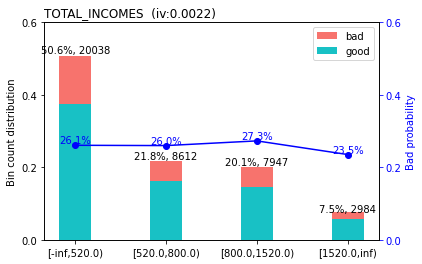

>>> Adjust breaks for (20/30) TOTAL_INCOMES?
1: next 
2: yes 
3: back
Selection: 1
-------- 21/30 STATE_OF_BIRTH --------
>>> dt[STATE_OF_BIRTH].describe(): 
count     39581
unique       28
top          BA
freq       6232
Name: STATE_OF_BIRTH, dtype: object 

>>> dt[STATE_OF_BIRTH].value_counts(): 
BA    6232
SP    4528
RS    3907
CE    3768
PE    3262
MG    2996
PR    1584
RN    1571
RJ    1473
PA    1335
AL    1300
PB    1256
MA    1124
GO     886
MT     682
PI     541
SC     528
ES     503
MS     394
AC     368
SE     289
AM     275
DF     239
TO     198
AP     182
RO     124
RR      35
XX       1
Name: STATE_OF_BIRTH, dtype: int64 

>>> Current breaks:
'XX%,%SC%,%PB%,%RS%,%PR','MG','GO%,%TO%,%RO%,%MA','PA%,%PE%,%PI%,%ES%,%BA%,%CE%,%RJ','RN%,%AP%,%SP%,%AM%,%MS','MT%,%AL%,%AC%,%SE%,%RR%,%DF' 



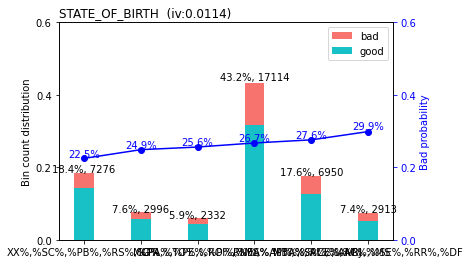

>>> Adjust breaks for (21/30) STATE_OF_BIRTH?
1: next 
2: yes 
3: back
Selection: 1
-------- 22/30 QUANT_ALL_BANKING_ACCOUNTS --------
>>> dt[QUANT_ALL_BANKING_ACCOUNTS].describe(): 
count    39581.000000
mean         0.716404
std          0.960220
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max          4.000000
Name: QUANT_ALL_BANKING_ACCOUNTS, dtype: float64 

>>> dt[QUANT_ALL_BANKING_ACCOUNTS].value_counts(): 
0    25415
2    14154
4       12
Name: QUANT_ALL_BANKING_ACCOUNTS, dtype: int64 

>>> Current breaks:
2.0 



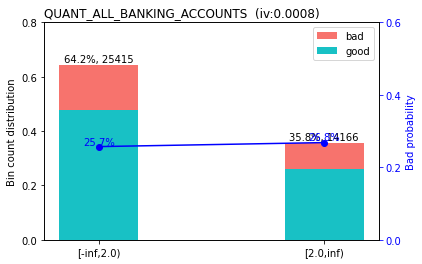

>>> Adjust breaks for (22/30) QUANT_ALL_BANKING_ACCOUNTS?
1: next 
2: yes 
3: back
Selection: 1
-------- 23/30 PRODUCT --------
>>> dt[PRODUCT].describe(): 
count    39581.000000
mean         1.273894
std          0.985131
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          7.000000
Name: PRODUCT, dtype: float64 

>>> dt[PRODUCT].value_counts(): 
1    33830
2     4733
7     1018
Name: PRODUCT, dtype: int64 

>>> Current breaks:
2.0 



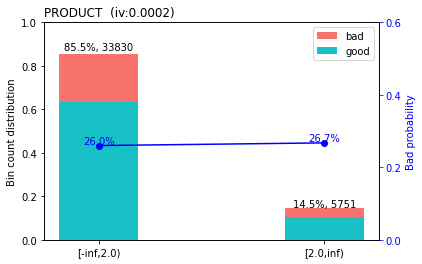

>>> Adjust breaks for (23/30) PRODUCT?
1: next 
2: yes 
3: back
Selection: 1
-------- 24/30 QUANT_DEPENDANTS --------
>>> dt[QUANT_DEPENDANTS].describe(): 
count    39581.000000
mean         0.629191
std          1.089694
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          6.000000
Name: QUANT_DEPENDANTS, dtype: float64 

>>> dt[QUANT_DEPENDANTS].value_counts(): 
0    26656
1     5609
2     4272
3     1937
4      704
5      294
6      109
Name: QUANT_DEPENDANTS, dtype: int64 

>>> Current breaks:
1.0,2.0,3.0 



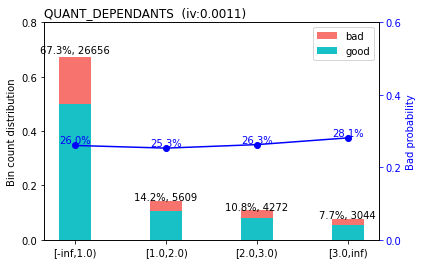

>>> Adjust breaks for (24/30) QUANT_DEPENDANTS?
1: next 
2: yes 
3: back
Selection: 1
-------- 25/30 RESIDENCE_TYPE --------
>>> dt[RESIDENCE_TYPE].describe(): 
count    39581.000000
mean         1.012228
std          0.378692
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: RESIDENCE_TYPE, dtype: float64 

>>> dt[RESIDENCE_TYPE].value_counts(): 
1.0    33899
2.0     3083
0.0     2599
Name: RESIDENCE_TYPE, dtype: int64 

>>> Current breaks:
1.0,2.0 



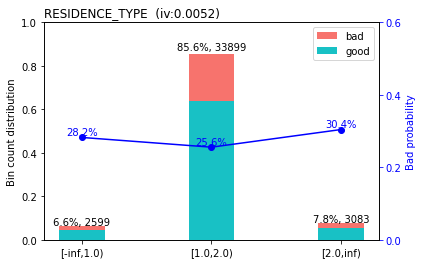

>>> Adjust breaks for (25/30) RESIDENCE_TYPE?
1: next 
2: yes 
3: back
Selection: 1
-------- 26/30 FLAG_EMAIL --------
>>> dt[FLAG_EMAIL].describe(): 
count    39581.000000
mean         0.801698
std          0.398726
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: FLAG_EMAIL, dtype: float64 

>>> dt[FLAG_EMAIL].value_counts(): 
1    31732
0     7849
Name: FLAG_EMAIL, dtype: int64 

>>> Current breaks:
1.0 



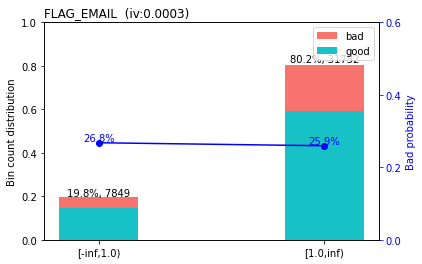

>>> Adjust breaks for (26/30) FLAG_EMAIL?
1: next 
2: yes 
3: back
Selection: 1
-------- 27/30 FLAG_CARDS --------
>>> dt[FLAG_CARDS].describe(): 
count    39581.000000
mean         0.211617
std          0.518956
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: FLAG_CARDS, dtype: float64 

>>> dt[FLAG_CARDS].value_counts(): 
0    33141
1     4583
2     1791
3       53
4       13
Name: FLAG_CARDS, dtype: int64 

>>> Current breaks:
1.0 



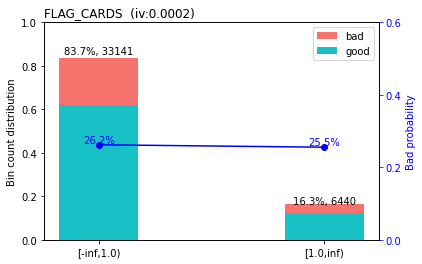

>>> Adjust breaks for (27/30) FLAG_CARDS?
1: next 
2: yes 
3: back
Selection: 1
-------- 28/30 COMPANY --------
>>> dt[COMPANY].describe(): 
count     39581
unique        2
top           N
freq      22106
Name: COMPANY, dtype: object 

>>> dt[COMPANY].value_counts(): 
N    22106
Y    17475
Name: COMPANY, dtype: int64 

>>> Current breaks:
'N','Y' 



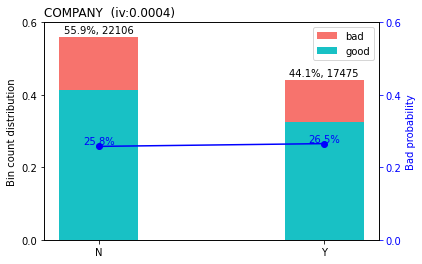

>>> Adjust breaks for (28/30) COMPANY?
1: next 
2: yes 
3: back
Selection: 1
-------- 29/30 PERSONAL_MONTHLY_INCOME --------
>>> dt[PERSONAL_MONTHLY_INCOME].describe(): 
count    39581.000000
mean       705.446446
std        642.666458
min         60.000000
25%        360.000000
50%        500.000000
75%        800.000000
max       9944.000000
Name: PERSONAL_MONTHLY_INCOME, dtype: float64 



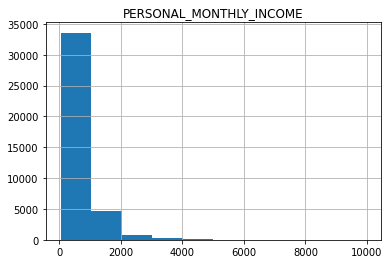

>>> Current breaks:
300.0,380.0,400.0,480.0,520.0,600.0,1520.0 



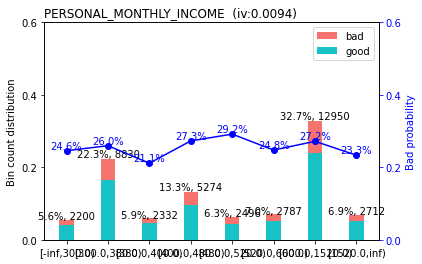

>>> Adjust breaks for (29/30) PERSONAL_MONTHLY_INCOME?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 380.0, 480.0, 1520.0
[INFO] creating woe binning ...
>>> Current breaks:
380.0, 480.0, 1520.0 



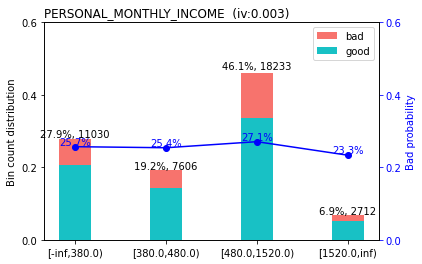

>>> Adjust breaks for (29/30) PERSONAL_MONTHLY_INCOME?
1: next 
2: yes 
3: back
Selection: 1
-------- 30/30 AVG_INCOME_STATE --------
>>> dt[AVG_INCOME_STATE].describe(): 
count    39581.000000
mean       705.446446
std         91.885470
min        527.180356
25%        657.218811
50%        700.605104
75%        777.453042
max       1160.009568
Name: AVG_INCOME_STATE, dtype: float64 



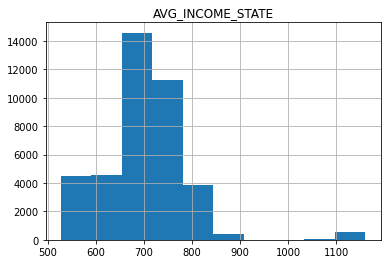

>>> Current breaks:
680.0,720.0,740.0,800.0 



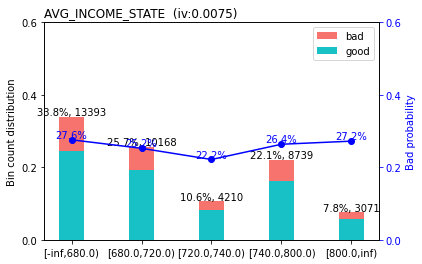

>>> Adjust breaks for (30/30) AVG_INCOME_STATE?
1: next 
2: yes 
3: back
Selection: 1


In [ ]:
breaks_adj = sc.woebin_adj(train, 'TARGET_LABEL_BAD=1', bins, adj_all_var = True)

In [ ]:
breaks_adj

"{'AGE': [23.0,33.0,44.0,47.0,55.0,70.0], 'APPLICATION_SUBMISSION_TYPE': ['Carga%,%Web'], 'AVG_INCOME_OCCUPATION_TYPE': [680.7458343301435,713.5490987484286], 'AVG_INCOME_PROFESSION_CODE': [684.796470391435,687.0593313458262,700.3521749161077], 'AVG_INCOME_STATE': [680.0,720.0,740.0,800.0], 'COMPANY': ['N','Y'], 'FLAG_CARDS': [1.0], 'FLAG_EMAIL': [1.0], 'FLAG_PROFESSIONAL_PHONE': ['N','Y'], 'FLAG_RESIDENCIAL_PHONE': ['Y','N'], 'MARITAL_STATUS': [2.0,3.0,4.0], 'MATE_EDUCATION_LEVEL': [1.0], 'MATE_PROFESSION_CODE': [1.0,18.0], 'MONTHS_IN_RESIDENCE': [6.0,11.0,16.0], 'OCCUPATION_TYPE': [1.0,2.0,4.0], 'OTHER_INCOMES': [90.0], 'PAYMENT_DAY': [10.0,15.0,20.0,25.0], 'PERSONAL_MONTHLY_INCOME': [380.0, 480.0, 1520.0], 'PRODUCT': [2.0], 'PROFESSIONAL_STATE': ['RO%,%SC%,%PB%,%RS','AP%,%TO%,%PR%,%PI','PA%,%MA','MG%,%MT%,%SP%,%GO%,%RJ','CE%,%ES%,%RN%,%PE%,%MS%,%BA','AM%,%AL%,%AC%,%DF%,%SE%,%RR'], 'PROFESSION_CODE': [2.0,9.0,11.0], 'QUANT_ALL_BANKING_ACCOUNTS': [2.0], 'QUANT_BANKING_ACCOUNTS': [1.0]

In [ ]:
bins_adj=sc.woebin(train, y="TARGET_LABEL_BAD=1", breaks_list=breaks_adj) #apply new cuts
train_woe = sc.woebin_ply(train, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(test, bins_adj) # Calculate WoE dataset (test)

[INFO] creating woe binning ...


/usr/local/lib/python3.7/dist-packages/scorecardpy/condition_fun.py:19: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: FLAG_ACSP_RECORD)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))


[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [ ]:
train_woe.head()

,TARGET_LABEL_BAD=1,FLAG_ACSP_RECORD,FLAG_RESIDENCIAL_PHONE_woe,OTHER_INCOMES_woe,MATE_EDUCATION_LEVEL_woe,RESIDENCIAL_STATE_woe,MONTHS_IN_RESIDENCE_woe,MATE_PROFESSION_CODE_woe,APPLICATION_SUBMISSION_TYPE_woe,AVG_INCOME_OCCUPATION_TYPE_woe,OCCUPATION_TYPE_woe,FLAG_PROFESSIONAL_PHONE_woe,STATE_OF_BIRTH_woe,PRODUCT_woe,QUANT_DEPENDANTS_woe,RESIDENCE_TYPE_woe,FLAG_EMAIL_woe,PERSONAL_MONTHLY_INCOME_woe,QUANT_BANKING_ACCOUNTS_woe,QUANT_CARS_woe,MARITAL_STATUS_woe,PAYMENT_DAY_woe,PROFESSIONAL_STATE_woe,AGE_woe,AVG_INCOME_PROFESSION_CODE_woe,PROFESSION_CODE_woe,QUANT_SPECIAL_BANKING_ACCOUNTS_woe,TOTAL_INCOMES_woe,QUANT_ALL_BANKING_ACCOUNTS_woe,FLAG_CARDS_woe,COMPANY_woe,AVG_INCOME_STATE_woe
0,1,N,-0.059463,0.005792,-0.018210,0.062566,-0.034226,0.004869,0.0,0.085236,0.095913,-0.023432,0.074821,-0.005555,-0.042673,-0.02898,-0.008568,0.049370,-0.020649,-0.016619,0.027153,-0.087150,0.063509,0.246765,0.006984,0.006591,-0.020649,0.060284,-0.020649,-0.029758,-0.017578,-0.045466
2,0,N,-0.059463,0.005792,-0.018210,0.062566,0.034710,0.004869,0.0,0.058481,0.095913,-0.023432,0.074821,-0.005555,-0.004248,-0.02898,-0.008568,0.049370,-0.020649,-0.016619,-0.103729,-0.087150,0.063509,0.246765,-0.178598,-0.178598,-0.020649,-0.001716,-0.020649,0.005733,-0.017578,-0.045466
4,1,N,-0.059463,0.005792,-0.018210,0.010937,-0.034226,0.004869,0.0,0.058481,0.095913,-0.023432,0.031242,-0.005555,-0.004248,-0.02898,-0.008568,0.049370,-0.020649,-0.016619,-0.103729,-0.157192,0.010456,-0.139973,0.006984,0.006591,-0.020649,0.060284,-0.020649,0.005733,-0.017578,0.012971
5,1,N,-0.059463,0.005792,0.038005,0.010937,0.053208,0.054997,0.0,0.058481,0.050330,-0.023432,-0.065670,0.032384,-0.004248,-0.02898,-0.008568,0.049370,0.036546,0.032359,-0.103729,-0.157192,0.010456,0.071341,0.006984,0.006591,0.036546,-0.001716,0.036546,0.005733,0.022027,-0.045466
6,1,N,-0.059463,0.005792,-0.018210,0.062566,0.053208,-0.122987,0.0,0.085236,0.095913,-0.023432,0.031242,-0.005555,0.007786,-0.02898,-0.008568,-0.021881,-0.020649,-0.016619,-0.103729,0.052689,0.063509,0.071341,-0.178598,-0.178598,-0.020649,-0.001716,-0.020649,0.005733,-0.017578,0.075510


## 2.3 Information value filtering

In [ ]:
sc.iv(train_woe, "TARGET_LABEL_BAD=1")

,variable,info_value
30,AGE_woe,0.071529
12,PAYMENT_DAY_woe,0.030830
11,MARITAL_STATUS_woe,0.025127
25,OCCUPATION_TYPE_woe,0.021743
17,AVG_INCOME_OCCUPATION_TYPE_woe,0.021431
14,FLAG_RESIDENCIAL_PHONE_woe,0.016742
18,PROFESSIONAL_STATE_woe,0.014476
4,RESIDENCIAL_STATE_woe,0.013873
29,STATE_OF_BIRTH_woe,0.011393
21,AVG_INCOME_STATE_woe,0.007489


As we can see, the IVs are pretty low for this dataset. Usually we use 0.02 as the thredhold to select features. But for this project, I will use 0.01 as the thredhold.

In [ ]:
train_woe=train_woe[['TARGET_LABEL_BAD=1', 'AGE_woe', 'PAYMENT_DAY_woe', 'MARITAL_STATUS_woe', 'OCCUPATION_TYPE_woe', 'AVG_INCOME_OCCUPATION_TYPE_woe', 'FLAG_RESIDENCIAL_PHONE_woe',
                    'PROFESSIONAL_STATE_woe', 'RESIDENCIAL_STATE_woe', 'STATE_OF_BIRTH_woe']]

In [ ]:
test_woe=test_woe[['TARGET_LABEL_BAD=1', 'AGE_woe', 'PAYMENT_DAY_woe', 'MARITAL_STATUS_woe', 'OCCUPATION_TYPE_woe', 'AVG_INCOME_OCCUPATION_TYPE_woe', 'FLAG_RESIDENCIAL_PHONE_woe',
                    'PROFESSIONAL_STATE_woe', 'RESIDENCIAL_STATE_woe', 'STATE_OF_BIRTH_woe']]

In [ ]:
#save the results
train_woe.to_csv("train_woe.csv", index = False)
test_woe.to_csv("test_woe.csv", index = False)

# Logistic Regression and Scorecards

## 3.1 Correlation analysis

In [ ]:
#load data
train_woe=pd.read_csv('train_woe.csv')
test_woe=pd.read_csv('test_woe.csv')

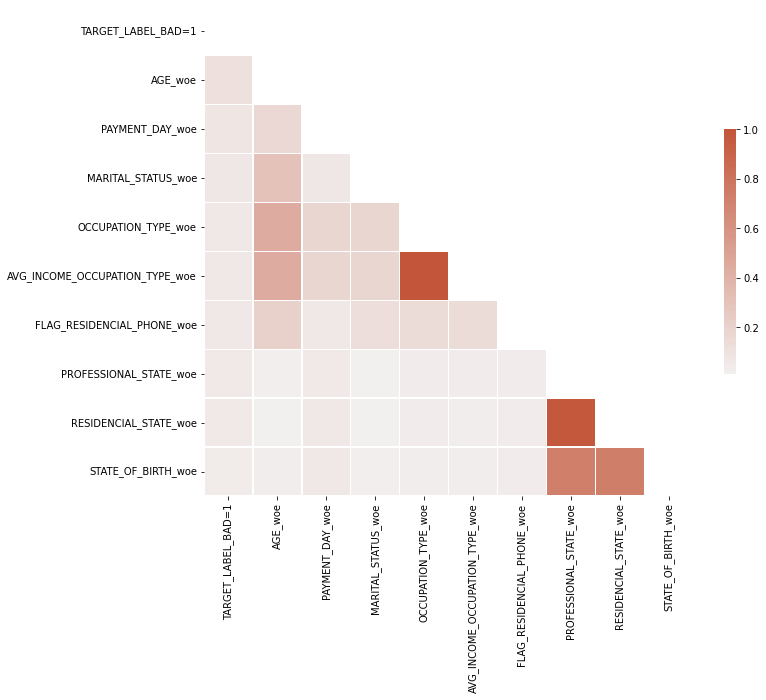

In [ ]:
# Compute the correlation matrix
corr = train_woe.corr()
corr = np.abs(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The high correlation between AVG_INCOME_OCCUPATION_TYPE_woe and OCCUPATION_TYPE_woe is high, which is reasonable since the former feature is derived from the latter one. So I keep the AVG_INCOME_OCCUPATION_TYPE_woe since the feature also contains personal_income information. 

I will keep the RESIDENTIAL_STATE_woe instead of PROFESSIONAL_STATE_woe since the missing values in the latter one was filled by the value from the former feature. 

I will delete the STATE_OF_BIRTH_woe since it has high correlation with PROFESSIONAL_STATE_woe and RESIDENTAIL_STATE_woe.

In [ ]:
train_woe=train_woe.drop(['OCCUPATION_TYPE_woe', 'PROFESSIONAL_STATE_woe', 'STATE_OF_BIRTH_woe'], axis="columns")

In [ ]:
# do the same on the test data
test_woe=test_woe.drop(['OCCUPATION_TYPE_woe', 'PROFESSIONAL_STATE_woe', 'STATE_OF_BIRTH_woe'], axis="columns")

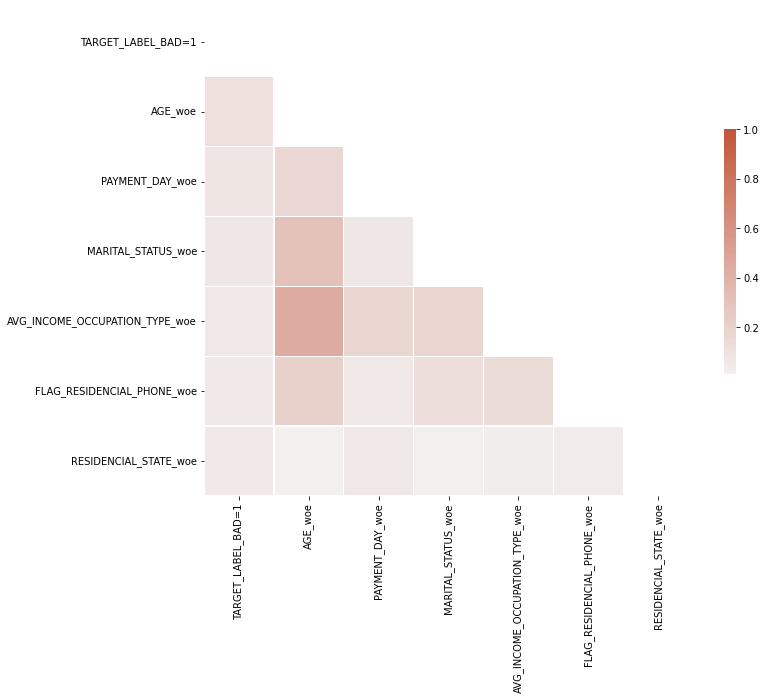

In [ ]:
# Compute the correlation matrix
corr = train_woe.corr()
corr = np.abs(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Now the correlation issue is gone.

## 3.2 Logistic regression 

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(penalty='elasticnet', # Type of penalization l1 = lasso, l2 = ridge, elasticnet
                                     Cs = [0.1, 1, 10, 100, 1000, 10000],        # How many parameters to try. Can also be a vector with parameters to try.
                                     tol=0.0001, # Tolerance for parameters
                                     cv = 3,     # How many CV folds to try. 3 or 5 should be enough.
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=251256082, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=2, # Show process. 1 is yes.
                                     solver = 'saga', # How to optimize.
                                     n_jobs = 2,      # Processes to use. Set to number of physical cores. 
                                     refit = True,     # If to retrain with the best parameter and all data after finishing.
                                     l1_ratios = np.arange(0, 1.01, 0.1), # The LASSO / Ridge ratios.
                                    )

In [ ]:
logreg.fit(X=train_woe.iloc[:, 1:], y=train_woe['TARGET_LABEL_BAD=1'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 22 epochs took 0 seconds
convergence after 22 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 9 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 9 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 22 epochs took 1 seconds
convergence after 11 epochs took 0 seconds
convergence after 22 epochs took 1 seconds
convergence after 9 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 9 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs

[Parallel(n_jobs=2)]: Done  33 out of  33 | elapsed:   11.9s finished


convergence after 23 epochs took 0 seconds


LogisticRegressionCV(Cs=[0.1, 1, 10, 100, 1000, 10000], class_weight='balanced',
                     cv=3,
                     l1_ratios=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                     n_jobs=2, penalty='elasticnet', random_state=251256082,
                     solver='saga', verbose=2)

In [ ]:
coef_df = pd.concat([pd.DataFrame({'column': train_woe.columns[1:]}), 
                    pd.DataFrame(np.transpose(logreg.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,AGE_woe,0.971624
1,PAYMENT_DAY_woe,0.732445
2,MARITAL_STATUS_woe,0.598525
3,AVG_INCOME_OCCUPATION_TYPE_woe,0.176442
4,FLAG_RESIDENCIAL_PHONE_woe,1.651352
5,RESIDENCIAL_STATE_woe,0.927104


In [ ]:
# predict test data
pred_test=logreg.predict(test_woe.iloc[:, 1:])
pred_test_prob=logreg.predict_proba(test_woe.iloc[:, 1:])

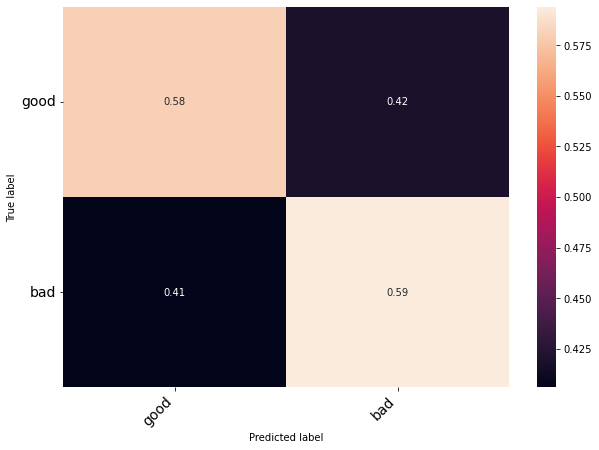

In [ ]:
# Calculate confusion matrix
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
confusion_matrix = confusion_matrix(y_true = test_woe['TARGET_LABEL_BAD=1'], 
                    y_pred = pred_test)

# Turn matrix to percentages
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


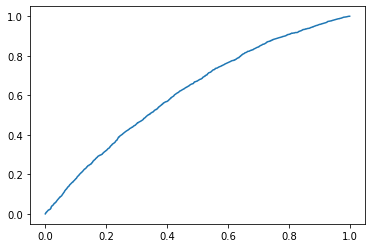

In [ ]:
# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _=roc_curve(test_woe['TARGET_LABEL_BAD=1'], pred_test_prob[:, 1])
ax=sns.lineplot(fpr, tpr)

In [ ]:
#AUC
auc(fpr, tpr)

0.6197269275547577

## 3.3 Scorecard

In [ ]:
breaks_adj={'AGE': [23.0,33.0,44.0,47.0,55.0,70.0], 
            'APPLICATION_SUBMISSION_TYPE': ['Carga%,%Web'], 
            'AVG_INCOME_OCCUPATION_TYPE': [680.7458343301435,713.5490987484286], 
            'AVG_INCOME_PROFESSION_CODE': [684.796470391435,687.0593313458262,700.3521749161077], 
            'AVG_INCOME_STATE': [680.0,720.0,740.0,800.0], 
            'COMPANY': ['N','Y'], 
            'FLAG_CARDS': [1.0], 
            'FLAG_EMAIL': [1.0], 
            'FLAG_PROFESSIONAL_PHONE': ['N','Y'], 
            'FLAG_RESIDENCIAL_PHONE': ['Y','N'], 
            'MARITAL_STATUS': [2.0,3.0,4.0], 
            'MATE_EDUCATION_LEVEL': [1.0], 
            'MATE_PROFESSION_CODE': [1.0,18.0], 
            'MONTHS_IN_RESIDENCE': [6.0,11.0,16.0], 
            'OCCUPATION_TYPE': [1.0,2.0,4.0], 
            'OTHER_INCOMES': [90.0], 
            'PAYMENT_DAY': [10.0,15.0,20.0,25.0], 
            'PERSONAL_MONTHLY_INCOME': [380.0, 480.0, 1520.0], 
            'PRODUCT': [2.0], 
            'PROFESSIONAL_STATE': ['RO%,%SC%,%PB%,%RS','AP%,%TO%,%PR%,%PI','PA%,%MA','MG%,%MT%,%SP%,%GO%,%RJ','CE%,%ES%,%RN%,%PE%,%MS%,%BA','AM%,%AL%,%AC%,%DF%,%SE%,%RR'], 
            'PROFESSION_CODE': [2.0,9.0,11.0], 
            'QUANT_ALL_BANKING_ACCOUNTS': [2.0], 
            'QUANT_BANKING_ACCOUNTS': [1.0], 
            'QUANT_CARS': [1.0], 
            'QUANT_DEPENDANTS': [1.0,2.0,3.0], 
            'QUANT_SPECIAL_BANKING_ACCOUNTS': [1.0], 
            'RESIDENCE_TYPE': [1.0,2.0], 
            'RESIDENCIAL_STATE': ['RO%,%SC%,%PB%,%RS%,%TO%,%PR','AP%,%PI%,%PA','MA%,%MG%,%SP%,%MT%,%RJ%,%GO','CE%,%ES%,%PE%,%RN%,%BA%,%MS','AM%,%AL%,%AC%,%DF%,%RR%,%SE'], 'STATE_OF_BIRTH': ['XX%,%SC%,%PB%,%RS%,%PR','MG','GO%,%TO%,%RO%,%MA','PA%,%PE%,%PI%,%ES%,%BA%,%CE%,%RJ','RN%,%AP%,%SP%,%AM%,%MS','MT%,%AL%,%AC%,%SE%,%RR%,%DF'], 
            'TOTAL_INCOMES': [520.0, 800.0,1520.0]}

train=pd.read_pickle('trainCleanNewVariable_noWoE.pkl')
bins_adj=sc.woebin(train, y="TARGET_LABEL_BAD=1", breaks_list=breaks_adj)

[INFO] creating woe binning ...


/usr/local/lib/python3.7/dist-packages/scorecardpy/condition_fun.py:19: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: FLAG_ACSP_RECORD)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))


In [ ]:
train_sc = sc.scorecard(bins_adj, # bins from the WoE
                        logreg,  # Trained logistic regression
                        train_woe.columns[1:], # The column names in the trained LR
                        points0=750, # Base points
                        odds0=0.02, # Base odds bads:goods
                        pdo=50
                        ) # PDO 

In [ ]:
train_sc

{'AGE':    variable          bin  points
 91      AGE  [-inf,23.0)   -33.0
 92      AGE  [23.0,33.0)   -17.0
 93      AGE  [33.0,44.0)    -5.0
 94      AGE  [44.0,47.0)     2.0
 95      AGE  [47.0,55.0)    10.0
 96      AGE  [55.0,70.0)    33.0
 97      AGE   [70.0,inf)    19.0,
 'AVG_INCOME_OCCUPATION_TYPE':                       variable                                    bin  points
 40  AVG_INCOME_OCCUPATION_TYPE               [-inf,680.7458343301435)     4.0
 41  AVG_INCOME_OCCUPATION_TYPE  [680.7458343301435,713.5490987484286)    -1.0
 42  AVG_INCOME_OCCUPATION_TYPE                [713.5490987484286,inf)    -1.0,
 'FLAG_RESIDENCIAL_PHONE':                  variable bin  points
 7  FLAG_RESIDENCIAL_PHONE   Y     7.0
 8  FLAG_RESIDENCIAL_PHONE   N   -34.0,
 'MARITAL_STATUS':           variable         bin  points
 76  MARITAL_STATUS  [-inf,2.0)    -9.0
 77  MARITAL_STATUS   [2.0,3.0)     4.0
 78  MARITAL_STATUS   [3.0,4.0)    -1.0
 79  MARITAL_STATUS   [4.0,inf)    11.0,
 'PAYMENT_

In [ ]:
#load the data
train_noWoE=pd.read_pickle('trainCleanNewVariable_noWoE.pkl')
test_noWoE=pd.read_pickle('testCleanNewVariable_noWoE.pkl')

In [ ]:
# Applying the credit score. Applies over the original data!
train_score = sc.scorecard_ply(train_noWoE, train_sc, 
                               print_step=0)
train_score

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,score
0,457.0
2,462.0
4,495.0
5,480.0
6,466.0
...,...
49993,481.0
49995,464.0
49996,414.0
49998,452.0


In [ ]:
test_score = sc.scorecard_ply(test_noWoE, train_sc, print_step=0)
test_score

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,score
1,469.0
3,461.0
12,447.0
13,455.0
15,433.0
...,...
49986,526.0
49987,471.0
49992,474.0
49994,496.0


In [ ]:
train_score.describe()

,score
count,39581.000000
mean,470.251004
std,28.483069
min,370.000000
25%,452.000000
50%,468.000000
75%,489.000000
max,546.000000


In [ ]:
test_score.describe()

,score
count,9908.000000
mean,471.685103
std,28.772126
min,374.000000
25%,452.000000
50%,469.000000
75%,491.000000
max,546.000000


## 3.4 Two-cut-off Points Strategy

In [ ]:
#get the prediction probability of train data
ypred=logreg.predict_proba(train_woe.iloc[:, 1:])[:, 1]

In [ ]:
#Concatenate the 'TARGET_LABEL_BAD=1', 'PERSONAL_MONTHLY_INCOME' columns from train data with the predicted probability.
# selected=train[['TARGET_LABEL_BAD=1', 'PERSONAL_MONTHLY_INCOME']]

cutoff_data=pd.concat([train[['TARGET_LABEL_BAD=1', 'PERSONAL_MONTHLY_INCOME']].reset_index(), pd.DataFrame(ypred)], axis=1)

cutoff_data=cutoff_data.rename(columns={'TARGET_LABEL_BAD=1': 'TARGET', 'PERSONAL_MONTHLY_INCOME': 'PERSONAL_MONTHLY_INCOME', 0: 'Y_PROB'})

In [ ]:
#caculate the potential cost for each customer (cost for good customers predicted as defaulter; cost for bad customers predicted as good)
def calculation(ytrue, income):
  if ytrue==0:
    return income*0.32*0.2
  else:
    return income*0.32

cutoff_data['POTENTIAL_COST']=cutoff_data.apply(lambda x: calculation(x.TARGET, x.PERSONAL_MONTHLY_INCOME), axis=1)

In [ ]:
cutoff_data.head()

,index,TARGET,PERSONAL_MONTHLY_INCOME,Y_PROB,POTENTIAL_COST
0,0,1,900.0,0.541406,288.0
1,2,0,500.0,0.520725,32.0
2,4,1,1200.0,0.403240,384.0
3,5,1,500.0,0.453469,160.0
4,6,1,320.0,0.504912,102.4


In [ ]:
# function to predict the label using cut-off point
def ylabel(cutoff, y_prob):
  if y_prob>cutoff:
    return 1
  else:
    return 0

In [ ]:
#Let's try these cut-off points
cutoff=[round(i, 2) for i in np.arange(0.4, 0.95, 0.05)]


In [ ]:
# make a dictionary to store the calculation
d={'cutoff': [], 'accepted_percentage': [], 'accuracy_good':[], 'accuracy_bad': [], 
   'accuracy_total':[], 'avg_good_cost':[], 'avg_bad_cost': [], 'total_good_cost': [], 
   'total_bad_cost': [], 'total_cost': []}

In [ ]:
def cutoff_table(cutoff, cutoff_data):
  for i in cutoff:
    d['cutoff'].append(i)
    cutoff_data['Ylabel']=cutoff_data.apply(lambda x: ylabel(i, x.Y_PROB), axis=1)
    d['accepted_percentage'].append(100*cutoff_data[(cutoff_data['Ylabel']==0)].shape[0]/cutoff_data.shape[0])
    # accuracy of good
    num_true_good=cutoff_data[cutoff_data['TARGET']==0].shape[0] #number of true good
    num_pred_good_inTrueGood=cutoff_data[(cutoff_data['TARGET']==0)&(cutoff_data['Ylabel']==0)].shape[0] #number of predicted good in true good
    accuracy_good=100*num_pred_good_inTrueGood/num_true_good
    d['accuracy_good'].append(accuracy_good)

    #accuracy of bad
    num_true_bad=cutoff_data[cutoff_data['TARGET']==1].shape[0] #number of true bad
    num_pred_bad_inTrueBad=cutoff_data[(cutoff_data['TARGET']==1)&(cutoff_data['Ylabel']==1)].shape[0] #number of predicted bad in true bad
    accuracy_bad=100*num_pred_bad_inTrueBad/num_true_bad
    d['accuracy_bad'].append(accuracy_bad)

    #accuracy of total
    accuracy_total=100*(num_pred_good_inTrueGood+num_pred_bad_inTrueBad)/cutoff_data.shape[0]
    d['accuracy_total'].append(accuracy_total)

    #total good cost
    total_good_cost=sum(cutoff_data[(cutoff_data['TARGET']==0)& (cutoff_data['Ylabel']==1)]['POTENTIAL_COST'])
    d['total_good_cost'].append(total_good_cost)

    #total_bad_cost
    total_bad_cost=sum(cutoff_data[(cutoff_data['TARGET']==1)& (cutoff_data['Ylabel']==0)]['POTENTIAL_COST'])
    d['total_bad_cost'].append(total_bad_cost)

    #total_cost
    total_cost=total_good_cost+total_bad_cost
    d['total_cost'].append(total_cost)

    #average good cost
    avg_good_cost=total_good_cost/cutoff_data[cutoff_data['TARGET']==0].shape[0]
    d['avg_good_cost'].append(avg_good_cost)

    #average bad cost
    avg_bad_cost=total_bad_cost/cutoff_data[cutoff_data['TARGET']==1].shape[0]
    d['avg_bad_cost'].append(avg_bad_cost)
  
  return d






In [ ]:
cutoff_value=cutoff_table(cutoff, cutoff_data)

In [ ]:
cutoff_point_table=pd.DataFrame.from_dict(cutoff_value)
cutoff_point_table

,cutoff,accepted_percentage,accuracy_good,accuracy_bad,accuracy_total,avg_good_cost,avg_bad_cost,total_good_cost,total_bad_cost,total_cost
0,0.40,17.692832,20.567618,90.441176,38.814077,35.089299,23.758867,1.026187e+06,2.455717e+05,1.271758e+06
1,0.45,31.366059,35.223115,79.547214,46.797706,27.574702,50.718034,8.064222e+05,5.242216e+05,1.330644e+06
2,0.50,51.403451,55.558215,60.352167,56.810086,17.583334,96.172483,5.142246e+05,9.940388e+05,1.508263e+06
3,0.55,71.913292,75.113695,37.142028,65.197949,9.112124,148.054920,2.664841e+05,1.530296e+06,1.796780e+06
4,0.60,87.590005,89.314413,17.289087,70.506051,3.733393,188.789123,1.091831e+05,1.951324e+06,2.060507e+06
5,0.65,96.048609,96.645580,5.640480,72.880928,1.156036,211.067467,3.380826e+04,2.181593e+06,2.215402e+06
6,0.70,99.267325,99.408446,1.131966,73.744979,0.181097,219.496239,5.296185e+03,2.268713e+06,2.274009e+06
7,0.75,99.911574,99.924773,0.125774,73.863722,0.020782,221.226591,6.077722e+02,2.286598e+06,2.287206e+06
8,0.80,100.000000,100.000000,0.000000,73.886461,0.000000,221.468046,0.000000e+00,2.289094e+06,2.289094e+06
9,0.85,100.000000,100.000000,0.000000,73.886461,0.000000,221.468046,0.000000e+00,2.289094e+06,2.289094e+06


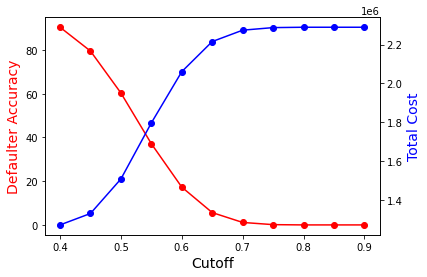

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(cutoff_point_table.cutoff, cutoff_point_table.accuracy_bad, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Cutoff",fontsize=14)
# set y-axis label
ax.set_ylabel("Defaulter Accuracy",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(cutoff_point_table.cutoff, cutoff_point_table.total_cost,color="blue",marker="o")
ax2.set_ylabel("Total Cost",color="blue",fontsize=14)
plt.show()

# Random Forest

In [ ]:
# load data
train_noWoE=pd.read_pickle('trainCleanNewVariable_noWoE.pkl')
test_noWoE=pd.read_pickle('testCleanNewVariable_noWoE.pkl')

In [ ]:
train_noWoE.head()

,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,RESIDENCIAL_STATE,FLAG_RESIDENCIAL_PHONE,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,QUANT_CARS,COMPANY,PROFESSIONAL_STATE,FLAG_PROFESSIONAL_PHONE,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,PRODUCT,FLAG_ACSP_RECORD,AGE,TARGET_LABEL_BAD=1,TOTAL_INCOMES,FLAG_CARDS,QUANT_ALL_BANKING_ACCOUNTS,AVG_INCOME_STATE,AVG_INCOME_OCCUPATION_TYPE,AVG_INCOME_PROFESSION_CODE
0,5,Web,3,1,RN,RN,Y,1.0,15.0,1,900.0,0.0,0,0,0,N,RN,N,9.0,4.0,18.0,6.0,1,N,32,1,900.0,2,0,700.605104,695.539871,700.352175
2,5,Web,2,0,RN,RN,Y,1.0,6.0,1,500.0,0.0,0,0,0,N,RN,N,11.0,5.0,18.0,6.0,1,N,27,0,500.0,0,0,700.605104,741.112513,684.796470
4,10,Web,2,0,RJ,RJ,Y,1.0,12.0,1,1200.0,0.0,0,0,0,N,RJ,N,9.0,5.0,18.0,6.0,1,N,48,1,1200.0,0,0,792.239283,741.112513,700.352175
5,10,Web,2,0,MG,MG,Y,1.0,4.0,1,500.0,0.0,1,1,1,Y,MG,N,9.0,2.0,0.0,0.0,2,N,40,1,500.0,0,2,681.927532,713.549099,700.352175
6,15,Carga,2,2,BA,BA,Y,1.0,1.0,1,320.0,0.0,0,0,0,N,BA,N,11.0,4.0,11.0,6.0,1,N,40,1,320.0,0,0,606.173818,695.539871,684.796470


In [ ]:
# covert some variables into categorical varibles.
train_noWoE['PAYMENT_DAY']=pd.Categorical(train_noWoE['PAYMENT_DAY'])
train_noWoE['MARITAL_STATUS']=pd.Categorical(train_noWoE['MARITAL_STATUS'])
train_noWoE['RESIDENCE_TYPE']=pd.Categorical(train_noWoE['RESIDENCE_TYPE'])
train_noWoE['FLAG_EMAIL']=pd.Categorical(train_noWoE['FLAG_EMAIL'])
train_noWoE['PROFESSION_CODE']=pd.Categorical(train_noWoE['PROFESSION_CODE'])
train_noWoE['OCCUPATION_TYPE']=pd.Categorical(train_noWoE['OCCUPATION_TYPE'])
train_noWoE['MATE_PROFESSION_CODE']=pd.Categorical(train_noWoE['MATE_PROFESSION_CODE'])
train_noWoE['MATE_EDUCATION_LEVEL']=pd.Categorical(train_noWoE['MATE_EDUCATION_LEVEL'])
train_noWoE['PRODUCT']=pd.Categorical(train_noWoE['PRODUCT'])

In [ ]:
# do the same thing for test data
test_noWoE['PAYMENT_DAY']=pd.Categorical(test_noWoE['PAYMENT_DAY'])
test_noWoE['MARITAL_STATUS']=pd.Categorical(test_noWoE['MARITAL_STATUS'])
test_noWoE['RESIDENCE_TYPE']=pd.Categorical(test_noWoE['RESIDENCE_TYPE'])
test_noWoE['FLAG_EMAIL']=pd.Categorical(test_noWoE['FLAG_EMAIL'])
test_noWoE['PROFESSION_CODE']=pd.Categorical(test_noWoE['PROFESSION_CODE'])
test_noWoE['OCCUPATION_TYPE']=pd.Categorical(test_noWoE['OCCUPATION_TYPE'])
test_noWoE['MATE_PROFESSION_CODE']=pd.Categorical(test_noWoE['MATE_PROFESSION_CODE'])
test_noWoE['MATE_EDUCATION_LEVEL']=pd.Categorical(test_noWoE['MATE_EDUCATION_LEVEL'])
test_noWoE['PRODUCT']=pd.Categorical(test_noWoE['PRODUCT'])

In [ ]:
#transform categorical variables into dummy variable.
train_noWoE=pd.get_dummies(train_noWoE, drop_first=True)
test_noWoE=pd.get_dummies(test_noWoE, drop_first=True)

In [ ]:
#find columns which exist in train data set but not in test data set.
for col in train_noWoE.columns:
  if col not in test_noWoE.columns:
    print(col)

STATE_OF_BIRTH_XX
MATE_PROFESSION_CODE_18.0
MATE_EDUCATION_LEVEL_6.0


In [ ]:
# Drop columns which exist in train data but not in test data.
train_noWoE.drop(['STATE_OF_BIRTH_XX', 'MATE_PROFESSION_CODE_18.0', 'MATE_EDUCATION_LEVEL_6.0'], axis='columns', inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Define the classifier
rf = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       criterion='entropy', # How to train the trees. Also supports gini.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.0001, # Minimum samples in a leaf. 
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.00001, # Minimum impurity decrease. This is 10^-4.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=2, # Parallel processing. Set to the number of cores you have. Watch your RAM!!
                       random_state=251256082, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced' # Balance the classes.
                                    )

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in range(500, 2500, 500)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(10, 110, 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, random_state=251256082, n_jobs = -1)

In [ ]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = train_noWoE.sample(frac = 0.5,               # The fraction to extract
                               random_state = 251256082,    # The seed.
                               )

In [ ]:
# Train grid search.
Xval_train=val_train.drop('TARGET_LABEL_BAD=1', axis='columns').values
yval_train=val_train['TARGET_LABEL_BAD=1'].values
rf_random.fit(Xval_train, yval_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   18.6s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    min_impurity_decrease=1e-05,
                                                    min_samples_leaf=0.0001,
                                                    n_estimators=1000, n_jobs=2,
                                                    oob_score=True,
                                                    random_state=251256082,
                                                    verbose=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50, 70, 90, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estima

In [ ]:
# Show best params
print('The best AUC is %.3f' % rf_random.best_score_)
rf_random.best_params_

The best AUC is 0.734


{'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}

In [ ]:
# Create random forest with best parameters
rf = RandomForestClassifier(n_estimators=500, # Number of trees to train
                       criterion='entropy', # How to train the trees. Also supports gini.
                       max_depth=70, # Max depth of the trees. Not necessary to change.
                       min_samples_split=5, # Minimum samples to create a split.
                       min_samples_leaf=1, # Minimum samples in a leaf. 
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.00001, # Minimum impurity decrease. This is 10^-4.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=2, # Parallel processing. Set to the number of cores you have. Watch your RAM!!
                       random_state=251256082, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced' # Balance the classes.
                                    )

In [ ]:
# Train over all training data.
Xtrain=train_noWoE.drop('TARGET_LABEL_BAD=1', axis='columns')
ytrain=train_noWoE['TARGET_LABEL_BAD=1']
rf.fit(Xtrain, ytrain)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   16.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   38.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   43.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=70, min_impurity_decrease=1e-05,
                       min_samples_split=5, n_estimators=500, n_jobs=2,
                       oob_score=True, random_state=251256082, verbose=1)

In [ ]:
# Apply the model to the test set.
Xtest=test_noWoE.drop('TARGET_LABEL_BAD=1', axis='columns')
ytest=test_noWoE['TARGET_LABEL_BAD=1']
rf_pred_test = rf.predict(Xtest)
rf_probs_test = rf.predict_proba(Xtest)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.2s finished


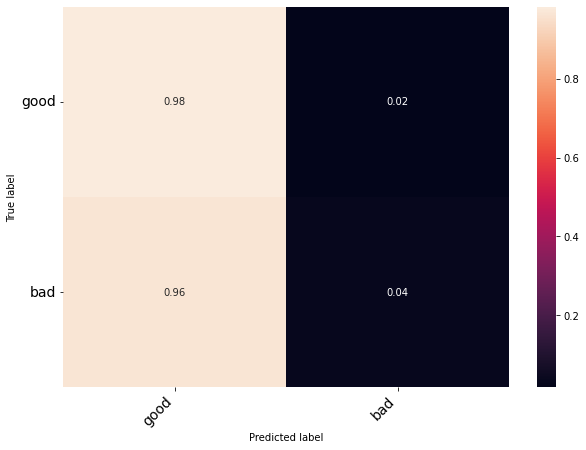

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = test_noWoE['TARGET_LABEL_BAD=1'], 
                    y_pred = rf_pred_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

auc is 0.621


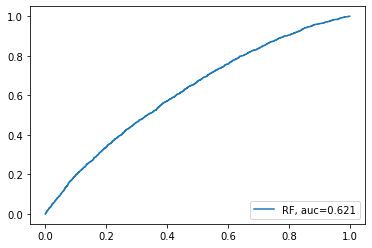

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_noWoE['TARGET_LABEL_BAD=1'], rf_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_noWoE['TARGET_LABEL_BAD=1'], 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)
print(f"auc is {auc}")

# Create and show the plot
plt.plot(fpr,tpr,label="RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#get the feature columns
columns=train_noWoE.drop('TARGET_LABEL_BAD=1', axis='columns').columns
columns

Index(['QUANT_DEPENDANTS', 'MONTHS_IN_RESIDENCE', 'PERSONAL_MONTHLY_INCOME',
       'OTHER_INCOMES', 'QUANT_BANKING_ACCOUNTS',
       'QUANT_SPECIAL_BANKING_ACCOUNTS', 'QUANT_CARS', 'AGE', 'TOTAL_INCOMES',
       'FLAG_CARDS',
       ...
       'OCCUPATION_TYPE_1.0', 'OCCUPATION_TYPE_2.0', 'OCCUPATION_TYPE_3.0',
       'OCCUPATION_TYPE_4.0', 'OCCUPATION_TYPE_5.0',
       'MATE_PROFESSION_CODE_1.0', 'MATE_PROFESSION_CODE_11.0',
       'MATE_EDUCATION_LEVEL_1.0', 'PRODUCT_2', 'PRODUCT_7'],
      dtype='object', length=121)

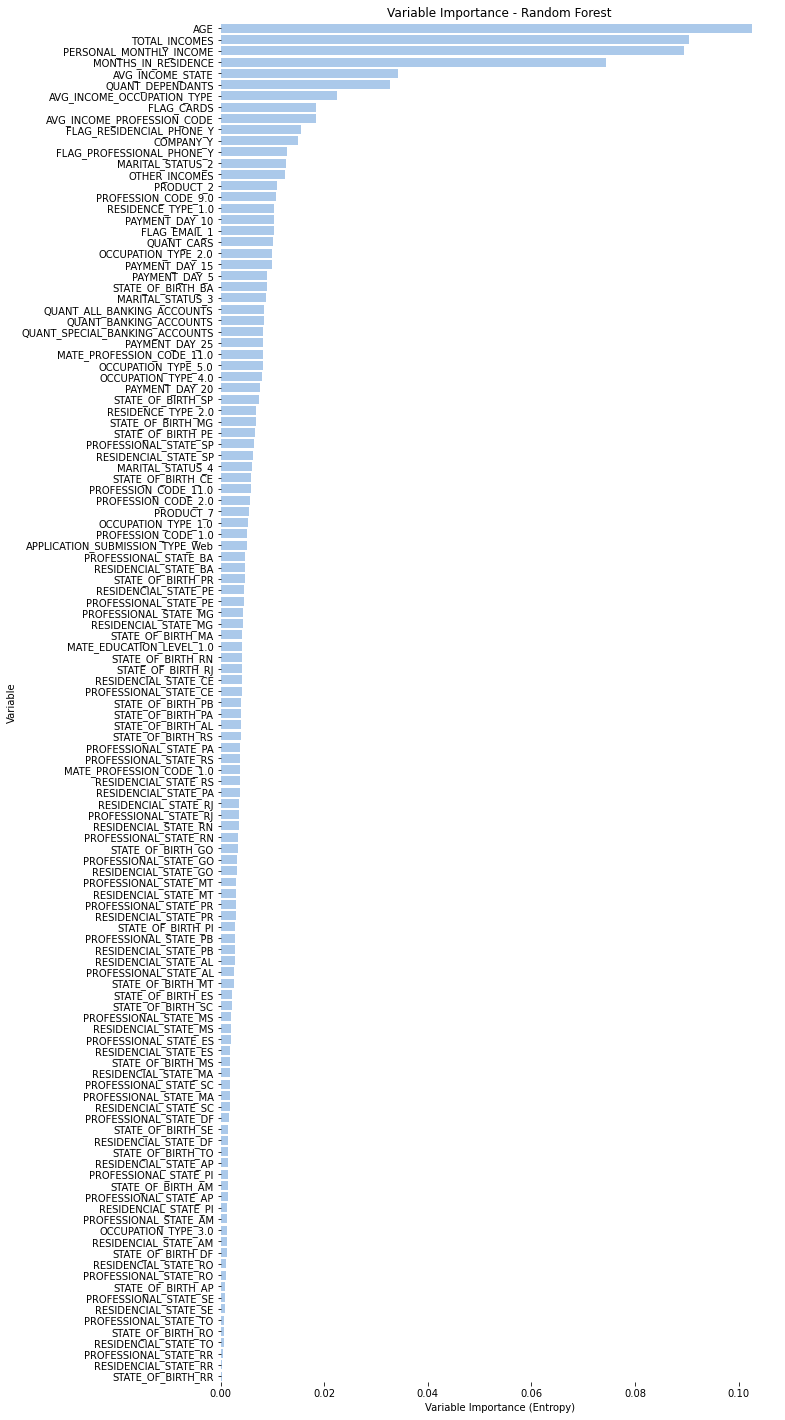

In [ ]:
# Plot variable importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(10, 25))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

# XGBoosting

In [ ]:
from xgboost import XGBClassifier 
#Define the classifier.
XGB = XGBClassifier(max_depth=2,       # Depth of each tree
                    learning_rate=0.1, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                    n_estimators=50,  # How many trees to use, the more the better, but decrease learning rate if many used.
                    verbosity=1, # If to show more errors or not.
                    objective='binary:logistic',  # Type of target variable.
                    booster='gbtree', # What to boost. Trees in this case.
                    n_jobs=2,  # Parallel jobs to run. Set your processor number.
                    gamma=0.001,   # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                    subsample=0.632,  # Subsample ratio. Can set lower
                    colsample_bytree=1,  # Subsample ratio of columns when constructing each tree.
                    colsample_bylevel=1,  # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                    colsample_bynode=1, # Subsample ratio of columns when constructing each split.
                    reg_alpha=1, # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                    reg_lambda=0, # Regularizer for first fit.
                    scale_pos_weight=1, # Balancing of positive and negative weights. G / B
                    base_score=0.5, # Global bias. Set to average of the target rate.
                    random_state=251256082, # Seed
                    missing=None,  # How are nulls encoded?
                    tree_method='hist', # How to train the trees?
                    #gpu_id=0                      # With which GPU? 
                    )

In [ ]:
# Define the parameters. Play with this grid!
param_grid = dict({'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3, 4],
                  'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })


In [ ]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = train_noWoE.sample(frac = 0.5,               # The fraction to extract
                               random_state = 251256082,    # The seed.
                               )

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(XGB,                 # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = 2,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [ ]:
# Train grid search.
Xval_train=val_train.drop('TARGET_LABEL_BAD=1', axis='columns').values
yval_train=val_train['TARGET_LABEL_BAD=1'].values
GridXGB.fit(Xval_train, yval_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(gamma=0.001, max_depth=2, n_estimators=50,
                                     n_jobs=2, random_state=251256082,
                                     reg_alpha=1, reg_lambda=0, subsample=0.632,
                                     tree_method='hist'),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [50, 100, 150]},
             refit=False, scoring='roc_auc', verbose=1)

In [ ]:
# Show best params
print('The best AUC is %.3f' % GridXGB.best_score_)
GridXGB.best_params_

The best AUC is 0.614


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [ ]:
# Create XGB with best parameters.
XGB = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'),       # Depth of each tree
                    learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                    n_estimators=GridXGB.best_params_.get('n_estimators'),  # How many trees to use, the more the better, but decrease learning rate if many used.
                    verbosity=1, # If to show more errors or not.
                    objective='binary:logistic',  # Type of target variable.
                    booster='gbtree', # What to boost. Trees in this case.
                    n_jobs=2,  # Parallel jobs to run. Set your processor number.
                    gamma=0.001,   # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                    subsample=0.632,  # Subsample ratio. Can set lower
                    colsample_bytree=1,  # Subsample ratio of columns when constructing each tree.
                    colsample_bylevel=1,  # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                    colsample_bynode=1, # Subsample ratio of columns when constructing each split.
                    reg_alpha=1, # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                    reg_lambda=0, # Regularizer for first fit.
                    scale_pos_weight=1, # Balancing of positive and negative weights. G / B
                    base_score=0.5, # Global bias. Set to average of the target rate.
                    random_state=251256082, # Seed
                    missing=None,  # How are nulls encoded?
                    tree_method='hist', # How to train the trees?
                    #gpu_id=0                      # With which GPU? 
                    )

In [ ]:
# Train over all training data.
Xtrain=train_noWoE.drop('TARGET_LABEL_BAD=1', axis='columns')
ytrain=train_noWoE['TARGET_LABEL_BAD=1']
XGB.fit(Xtrain, ytrain)

XGBClassifier(gamma=0.001, n_jobs=2, random_state=251256082, reg_alpha=1,
              reg_lambda=0, subsample=0.632, tree_method='hist')

In [ ]:
#save the model 
import pickle
filename = 'XGBoosting_model.sav'
pickle.dump(XGB, open(filename, 'wb'))

In [ ]:
#get the feature columns
columns=train_noWoE.drop('TARGET_LABEL_BAD=1', axis='columns').columns
columns

Index(['QUANT_DEPENDANTS', 'MONTHS_IN_RESIDENCE', 'PERSONAL_MONTHLY_INCOME',
       'OTHER_INCOMES', 'QUANT_BANKING_ACCOUNTS',
       'QUANT_SPECIAL_BANKING_ACCOUNTS', 'QUANT_CARS', 'AGE', 'TOTAL_INCOMES',
       'FLAG_CARDS',
       ...
       'OCCUPATION_TYPE_1.0', 'OCCUPATION_TYPE_2.0', 'OCCUPATION_TYPE_3.0',
       'OCCUPATION_TYPE_4.0', 'OCCUPATION_TYPE_5.0',
       'MATE_PROFESSION_CODE_1.0', 'MATE_PROFESSION_CODE_11.0',
       'MATE_EDUCATION_LEVEL_1.0', 'PRODUCT_2', 'PRODUCT_7'],
      dtype='object', length=121)

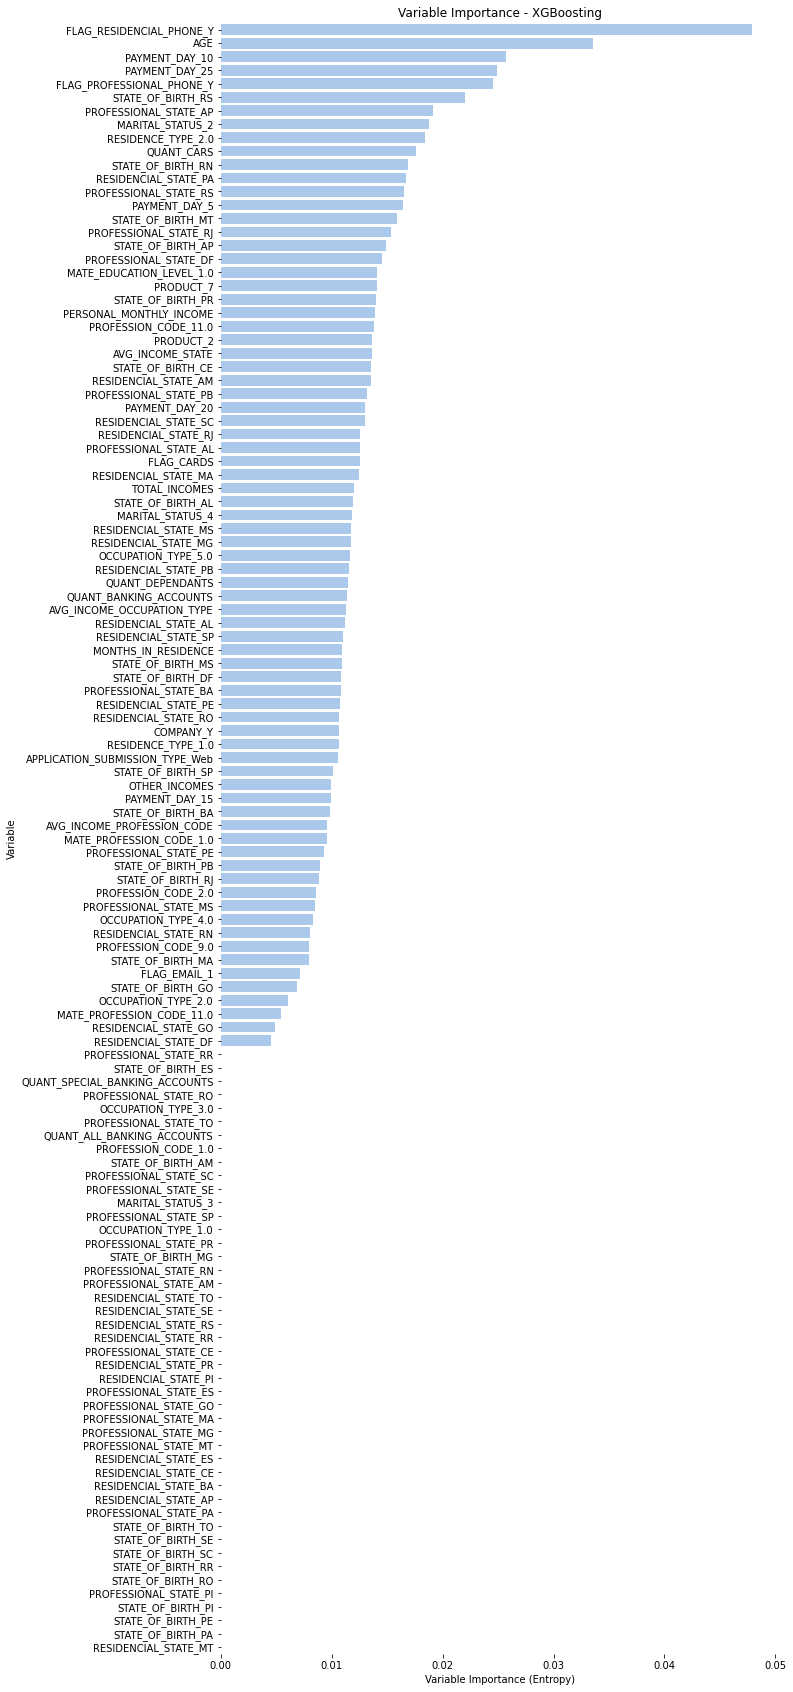

In [ ]:
# Plot variable importance
importances = XGB.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(10, 30))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

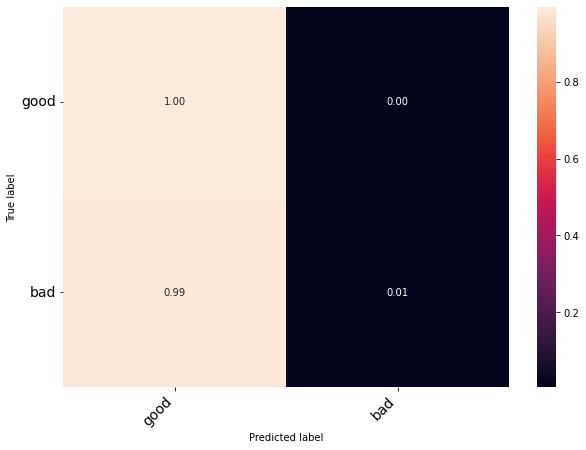

In [ ]:
# Calculate probability
#XGB= pickle.load(open('XGBoosting_model.sav', 'rb'))
Xtest=test_noWoE.drop('TARGET_LABEL_BAD=1', axis='columns')
ytest=test_noWoE['TARGET_LABEL_BAD=1']
XGBPredTest = XGB.predict(Xtest)
xg_probs_test = XGB.predict_proba(Xtest)
xg_probs_test = xg_probs_test[:, 1]

# Calculate confusion matrix
confusion_matrix_xgb = confusion_matrix(y_true = ytest, 
                    y_pred = XGBPredTest)

# Turn matrix to percentages
confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xgb, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

auc is : 0.625


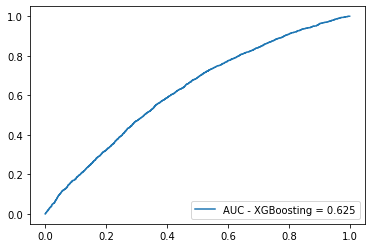

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(ytest, 
                                 xg_probs_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = ytest, 
                             y_score = xg_probs_test),
               decimals = 3)
print(f"auc is : {auc}")

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()